In [2]:
 %pip install duckdb
 %pip install polars

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ------------- -------------------------- 262.1/772.7 kB ? eta -:--:--
   --------------------------- ------------ 524.3/772.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 772.7/772.7 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.1 MB ? eta -:--:--
    --------------------------------------- 0.5/40.1 MB 1.7 MB/s eta 0:00:24
   - -------------------------------------- 1.6/40.1 MB 3.5 MB/s eta 0:00:12
   -- ------------------------------------- 2.9/40.1 MB 4.5 MB/s eta 0:00:09
   ----- ---------------------------------- 5.2/40.1 MB 6.2 MB/s eta 0:00:06
   --------- --------------------------

Data setup and performance foundations
Efficient I/O and caching
- Remote parquet scanning: Use DuckDB’s parquet_scan to query remote files with predicate and projection pushdown.
- HTTP caching: Enable DuckDB’s HTTPFS for caching remote parquet locally to accelerate iterative work.


In [84]:
import duckdb, polars as pl

con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("SET enable_object_cache=true;")

# Links diretos (RAW do GitHub)
files = {
    "ratings": "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/ratings.parquet",
    "movies":  "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/movies.parquet",
    "tags":    "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/tags.parquet"
}

# Criar views
con.execute(f"CREATE OR REPLACE VIEW ratings AS SELECT * FROM parquet_scan('{files['ratings']}')")
con.execute(f"CREATE OR REPLACE VIEW movies  AS SELECT * FROM parquet_scan('{files['movies']}')")
con.execute(f"CREATE OR REPLACE VIEW tags    AS SELECT * FROM parquet_scan('{files['tags']}')")

In [52]:
# 1) Distribuição de notas
stat1_ratings_dist = q("""
    SELECT rating::DOUBLE AS rating, COUNT(*) AS freq
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")

# 2) Top 10 filmes mais avaliados
stat2_most_rated = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 10
""")

# 3) Top 10 filmes com melhor média (≥100 avaliações)
stat3_best_rated_100 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 10
""")

# 4) Popularidade por gênero
stat4_genre_pop = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    SELECT genre, COUNT(*) AS n_movies
    FROM exploded
    GROUP BY genre
    ORDER BY n_movies DESC
""")

# 5) Atividade de avaliações ao longo do tempo (mensal)
stat5_ratings_by_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(*) AS n_ratings,
           AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 6) Ciclo de vida por ano de lançamento
stat6_by_year = q("""
    SELECT CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) AS year_guess,
           COUNT(r.rating) AS n_ratings,
           AVG(r.rating) AS avg_rating
    FROM movies m
    LEFT JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
      AND TRY_CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) IS NOT NULL
    GROUP BY year_guess
    ORDER BY year_guess
""")

# 7) Atividade por filme
stat7_movie_activity = q("""
    SELECT movieId, COUNT(*) AS n_ratings, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")

# 8) Tags mais frequentes
stat8_tags_freq = q("""
    SELECT LOWER(TRIM(tag)) AS tag, COUNT(*) AS freq
    FROM tags
    WHERE tag IS NOT NULL AND TRIM(tag) <> ''
    GROUP BY LOWER(TRIM(tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 9) Co-ocorrência de gêneros
stat9_genre_pairs = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    ),
    pairs AS (
        SELECT a.movieId, LEAST(a.genre,b.genre) AS g1, GREATEST(a.genre,b.genre) AS g2
        FROM exploded a
        JOIN exploded b ON a.movieId = b.movieId AND a.genre < b.genre
    )
    SELECT g1, g2, COUNT(*) AS n
    FROM pairs
    GROUP BY g1, g2
    ORDER BY n DESC
    LIMIT 20
""")

# 10) Média global
stat10_global_mean = q("SELECT AVG(rating) AS gmean FROM ratings")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [53]:
print("\n=== 1) Distribuição de notas ===")
print(stat1_ratings_dist)

print("\n=== 2) Top 10 filmes mais avaliados ===")
print(stat2_most_rated)

print("\n=== 3) Top 10 filmes com melhor média (≥100 avaliações) ===")
print(stat3_best_rated_100)

print("\n=== 4) Popularidade por gênero ===")
print(stat4_genre_pop)

print("\n=== 5) Atividade de avaliações ao longo do tempo (mensal) ===")
print(stat5_ratings_by_month.head(15))

print("\n=== 6) Ciclo de vida por ano de lançamento ===")
print(stat6_by_year)

print("\n=== 7) Atividade por filme (long tail) ===")
print(stat7_movie_activity.head(20))

print("\n=== 8) Tags mais frequentes ===")
print(stat8_tags_freq)

print("\n=== 9) Co-ocorrência de gêneros ===")
print(stat9_genre_pairs)

print("\n=== 10) Média global de todas as avaliações ===")
print(stat10_global_mean)


=== 1) Distribuição de notas ===
shape: (10, 2)
┌────────┬─────────┐
│ rating ┆ freq    │
│ ---    ┆ ---     │
│ f64    ┆ i64     │
╞════════╪═════════╡
│ 0.5    ┆ 94988   │
│ 1.0    ┆ 384180  │
│ 1.5    ┆ 118278  │
│ 2.0    ┆ 790306  │
│ 2.5    ┆ 370178  │
│ 3.0    ┆ 2356676 │
│ 3.5    ┆ 879764  │
│ 4.0    ┆ 2875850 │
│ 4.5    ┆ 585022  │
│ 5.0    ┆ 1544812 │
└────────┴─────────┘

=== 2) Top 10 filmes mais avaliados ===
shape: (10, 3)
┌─────────────────────────────────┬───────────┬────────────┐
│ title                           ┆ n_ratings ┆ avg_rating │
│ ---                             ┆ ---       ┆ ---        │
│ str                             ┆ i64       ┆ f64        │
╞═════════════════════════════════╪═══════════╪════════════╡
│ Pulp Fiction (1994)             ┆ 34864     ┆ 4.157426   │
│ Forrest Gump (1994)             ┆ 34457     ┆ 4.013582   │
│ Silence of the Lambs, The (199… ┆ 33668     ┆ 4.2042     │
│ Jurassic Park (1993)            ┆ 32631     ┆ 3.661564   │
│ Shawshan

In [54]:
# 11) Distribuição de nº de avaliações por usuário
stat11_user_activity = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
""")

# 12) Distribuição da média de notas por usuário
stat12_user_avg = q("""
    SELECT userId, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY userId
""")

# 13) Top 20 usuários mais ativos
stat13_user_top20 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
    ORDER BY n_ratings DESC
    LIMIT 20
""")

# 14) Notas por gênero
stat14_ratings_genre = q("""
    WITH exploded AS (
        SELECT r.rating, UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT genre, rating
    FROM exploded
""")

# 15) Usuários únicos por mês
stat15_users_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT userId) AS n_users
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 16) Filmes distintos avaliados por mês
stat16_movies_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT movieId) AS n_movies
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 17) Relação nº de avaliações x média do filme
stat17_movie_activity = q("""
    SELECT movieId, COUNT(*) AS n_ratings, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")

# 18) Distribuição de avaliações por hora
stat18_ratings_hour = q("""
    SELECT EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY hour
    ORDER BY hour
""")

# 19) Distribuição de avaliações por dia da semana
stat19_ratings_weekday = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY dow
    ORDER BY dow
""")

# 20) Filmes mais polarizadores
stat20_polarizing = q("""
    SELECT m.title, COUNT(*) AS n, STDDEV(rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY std DESC
    LIMIT 15
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [55]:
print("\n=== 11) Distribuição de nº de avaliações por usuário ===")
print(stat11_user_activity.describe())

print("\n=== 12) Distribuição da média de notas por usuário ===")
print(stat12_user_avg.describe())

print("\n=== 13) Top 20 usuários mais ativos ===")
print(stat13_user_top20)

print("\n=== 14) Notas por gênero (amostra) ===")
print(stat14_ratings_genre.head(20))

print("\n=== 15) Usuários únicos por mês (primeiros 12 meses) ===")
print(stat15_users_month.head(12))

print("\n=== 16) Filmes distintos avaliados por mês (primeiros 12 meses) ===")
print(stat16_movies_month.head(12))

print("\n=== 17) Relação nº de avaliações x média do filme (top 20) ===")
print(stat17_movie_activity.head(20))

print("\n=== 18) Distribuição de avaliações por hora ===")
print(stat18_ratings_hour)

print("\n=== 19) Distribuição de avaliações por dia da semana ===")
print(stat19_ratings_weekday)

print("\n=== 20) Filmes mais polarizadores ===")
print(stat20_polarizing)


=== 11) Distribuição de nº de avaliações por usuário ===
shape: (9, 3)
┌────────────┬──────────────┬───────────┐
│ statistic  ┆ userId       ┆ n_ratings │
│ ---        ┆ ---          ┆ ---       │
│ str        ┆ f64          ┆ f64       │
╞════════════╪══════════════╪═══════════╡
│ count      ┆ 69878.0      ┆ 69878.0   │
│ null_count ┆ 0.0          ┆ 0.0       │
│ mean       ┆ 35782.217393 ┆ 143.10733 │
│ std        ┆ 20613.909098 ┆ 216.71258 │
│ min        ┆ 1.0          ┆ 20.0      │
│ 25%        ┆ 17943.0      ┆ 35.0      │
│ 50%        ┆ 35799.0      ┆ 69.0      │
│ 75%        ┆ 53620.0      ┆ 156.0     │
│ max        ┆ 71567.0      ┆ 7359.0    │
└────────────┴──────────────┴───────────┘

=== 12) Distribuição da média de notas por usuário ===
shape: (9, 3)
┌────────────┬──────────────┬────────────┐
│ statistic  ┆ userId       ┆ avg_rating │
│ ---        ┆ ---          ┆ ---        │
│ str        ┆ f64          ┆ f64        │
╞════════════╪══════════════╪════════════╡
│ count      

In [56]:
# 21) Filmes mais consensuais
stat21_consensus = q("""
    SELECT m.title, COUNT(*) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY std ASC
    LIMIT 15
""")

# 22) Nº de tags por usuário
stat22_tags_user = q("""
    SELECT userId, COUNT(*) AS n_tags
    FROM tags
    GROUP BY userId
""")

# 23) Tags mais associadas a notas altas
stat23_tags_high = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, COUNT(*) AS freq
    FROM tags t
    JOIN ratings r USING (movieId)
    WHERE r.rating >= 4
    GROUP BY LOWER(TRIM(t.tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 24) Tags mais associadas a notas baixas
stat24_tags_low = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, COUNT(*) AS freq
    FROM tags t
    JOIN ratings r USING (movieId)
    WHERE r.rating <= 2
    GROUP BY LOWER(TRIM(t.tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 25) Evolução da nota média por gênero ao longo do tempo
stat25_genre_time = q("""
    WITH exploded AS (
        SELECT r.rating,
               TO_TIMESTAMP(r.timestamp) AS ts,
               UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT DATE_TRUNC('year', ts) AS year,
           genre,
           AVG(rating) AS avg_rating,
           COUNT(*) AS n
    FROM exploded
    GROUP BY year, genre
    HAVING COUNT(*) >= 500
    ORDER BY year
""")

# 26) Clássicos antigos (antes de 1960)
stat26_old_classics = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(19%'
      AND CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) < 1960
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY avg_rating DESC
    LIMIT 15
""")

# 27) Filmes recentes (2000+)
stat27_recent_movies = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(20%'
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY avg_rating DESC
    LIMIT 15
""")

# 28) Nota média por década
stat28_decades = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           AVG(r.rating) AS avg_rating,
           COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade
    ORDER BY decade
""")

# 29) Nº de gêneros por filme
stat29_genres_count = q("""
    SELECT movieId, COUNT(*) AS n_genres
    FROM (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS g
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    GROUP BY movieId
""")

# 30) Filmes com mais gêneros
stat30_hybrid_movies = q("""
    SELECT m.title, COUNT(*) AS n_genres
    FROM movies m, UNNEST(STRING_SPLIT(m.genres, '|')) g
    WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    GROUP BY m.title
    ORDER BY n_genres DESC
    LIMIT 15
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [58]:
print("\n=== 21) Filmes mais consensuais ===")
print(stat21_consensus)

print("\n=== 22) Nº de tags por usuário (estatísticas) ===")
print(stat22_tags_user.describe())

print("\n=== 23) Tags mais associadas a notas altas ===")
print(stat23_tags_high)

print("\n=== 24) Tags mais associadas a notas baixas ===")
print(stat24_tags_low)

print("\n=== 25) Evolução da nota média por gênero (amostra) ===")
print(stat25_genre_time.head(20))

print("\n=== 26) Clássicos antigos mais bem avaliados ===")
print(stat26_old_classics)

print("\n=== 27) Filmes recentes mais bem avaliados ===")
print(stat27_recent_movies)

print("\n=== 28) Nota média por década ===")
print(stat28_decades)

print("\n=== 29) Nº de gêneros por filme (estatísticas) ===")
print(stat29_genres_count.describe())

print("\n=== 30) Filmes com mais gêneros ===")
print(stat30_hybrid_movies)


=== 21) Filmes mais consensuais ===
shape: (15, 3)
┌─────────────────────────────────┬──────┬──────────┐
│ title                           ┆ n    ┆ std      │
│ ---                             ┆ ---  ┆ ---      │
│ str                             ┆ i64  ┆ f64      │
╞═════════════════════════════════╪══════╪══════════╡
│ Gone Baby Gone (2007)           ┆ 734  ┆ 0.641226 │
│ Last King of Scotland, The (20… ┆ 1281 ┆ 0.644991 │
│ Touching the Void (2003)        ┆ 888  ┆ 0.65028  │
│ Bank Job, The (2008)            ┆ 605  ┆ 0.657802 │
│ Murder on the Orient Express (… ┆ 538  ┆ 0.664082 │
│ …                               ┆ …    ┆ …        │
│ Good bye, Lenin! (2003)         ┆ 1662 ┆ 0.672287 │
│ Hotel Rwanda (2004)             ┆ 3181 ┆ 0.672562 │
│ Inside Man (2006)               ┆ 1959 ┆ 0.673569 │
│ Day of the Jackal, The (1973)   ┆ 807  ┆ 0.675559 │
│ Presumed Innocent (1990)        ┆ 618  ┆ 0.677258 │
└─────────────────────────────────┴──────┴──────────┘

=== 22) Nº de tags por usuári

In [69]:
# 31) Distribuição de notas por década
stat31 = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           rating, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade, rating
    ORDER BY decade, rating
""")

# 32) Filmes mais avaliados em cada década
stat32 = q("""
    SELECT decade, title, n_ratings
    FROM (
        SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
               m.title, COUNT(r.rating) AS n_ratings,
               ROW_NUMBER() OVER (
                   PARTITION BY (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10
                   ORDER BY COUNT(r.rating) DESC
               ) AS rk
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.title LIKE '%(%)'
        GROUP BY decade, m.title
    ) t
    WHERE rk = 1
""")

# 33) Filmes com maior proporção de notas 5
stat33 = q("""
    SELECT m.title,
           COUNT(*) FILTER (WHERE r.rating=5.0)*1.0/COUNT(*) AS prop_5,
           COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY prop_5 DESC
    LIMIT 20
""")

# 34) Filmes com maior proporção de notas 0.5
stat34 = q("""
    SELECT m.title,
           COUNT(*) FILTER (WHERE r.rating=0.5)*1.0/COUNT(*) AS prop_05,
           COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY prop_05 DESC
    LIMIT 20
""")

# 35) Usuários que mais usam notas extremas
stat35 = q("""
    SELECT userId,
           COUNT(*) FILTER (WHERE rating=0.5 OR rating=5.0)*1.0/COUNT(*) AS prop_extremas,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY prop_extremas DESC
    LIMIT 20
""")

# 36) Heatmap hora x dia da semana
stat36 = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n
    FROM ratings
    GROUP BY dow, hour
    ORDER BY dow, hour
""")

# 37) Filmes mais tagueados
stat37 = q("""
    SELECT m.title, COUNT(t.tag) AS n_tags
    FROM tags t
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_tags DESC
    LIMIT 20
""")

# 38) Tags mais populares por década
stat38 = q("""
    SELECT decade, tag, n
    FROM (
        SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
               LOWER(TRIM(tag)) AS tag, COUNT(*) AS n,
               ROW_NUMBER() OVER (
                   PARTITION BY (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10
                   ORDER BY COUNT(*) DESC
               ) AS rk
        FROM tags t
        JOIN movies m USING (movieId)
        WHERE m.title LIKE '%(%)'
        GROUP BY decade, tag
    ) q
    WHERE rk <= 5
""")

# 39) Filmes com maior variação de notas ao longo do tempo
stat39 = q("""
    SELECT m.title, STDDEV(avg_rating) AS std_time, COUNT(*) AS n_periods
    FROM (
        SELECT movieId, DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, AVG(rating) AS avg_rating
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY std_time DESC
    LIMIT 20
""")

# 40) Evolução da quantidade de tags ao longo do tempo
stat40 = q("""
    SELECT DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, COUNT(*) AS n_tags
    FROM tags
    GROUP BY ano
    ORDER BY ano
""")

# 41) Filmes mais avaliados por novatos (≤10 avaliações)
stat41 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE r.userId IN (
        SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) <= 10
    )
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 42) Filmes mais avaliados por veteranos (≥1000 avaliações)
stat42 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE r.userId IN (
        SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) >= 1000
    )
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 43) Diferença de média entre novatos e veteranos
stat43 = q("""
    WITH novatos AS (
        SELECT movieId, AVG(rating) AS avg_nov
        FROM ratings
        WHERE userId IN (SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) <= 10)
        GROUP BY movieId
    ),
    veteranos AS (
        SELECT movieId, AVG(rating) AS avg_vet
        FROM ratings
        WHERE userId IN (SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) >= 1000)
        GROUP BY movieId
    )
    SELECT m.title, avg_nov, avg_vet, (avg_vet-avg_nov) AS diff
    FROM movies m
    JOIN novatos n USING (movieId)
    JOIN veteranos v USING (movieId)
    WHERE (SELECT COUNT(*) FROM ratings r WHERE r.movieId=m.movieId) >= 500
    ORDER BY ABS(diff) DESC
    LIMIT 20
""")

# 44) Filmes mais avaliados em finais de semana
stat44 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) IN (0,6)
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 45) Filmes mais avaliados em dias úteis
stat45 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) BETWEEN 1 AND 5
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 46) Diferença de média semana vs fim de semana
stat46 = q("""
    WITH semana AS (
        SELECT movieId, AVG(rating) AS avg_semana
        FROM ratings
        WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) BETWEEN 1 AND 5
        GROUP BY movieId
    ),
    fimsemana AS (
        SELECT movieId, AVG(rating) AS avg_fds
        FROM ratings
        WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) IN (0,6)
        GROUP BY movieId
    )
    SELECT m.title, avg_semana, avg_fds, (avg_fds-avg_semana) AS diff
    FROM movies m
    JOIN semana s USING (movieId)
    JOIN fimsemana f USING (movieId)
    WHERE (SELECT COUNT(*) FROM ratings r WHERE r.movieId=m.movieId) >= 500
    ORDER BY ABS(diff) DESC
    LIMIT 20
""")

# 47) Filmes com maior crescimento de avaliações ao longo dos anos
stat47 = q("""
    SELECT m.title, MAX(n)-MIN(n) AS crescimento
    FROM (
        SELECT movieId, DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, COUNT(*) AS n
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY crescimento DESC
    LIMIT 20
""")

# 48) Filmes com maior queda de popularidade (redução de avaliações ao longo dos anos)
stat48 = q("""
    SELECT m.title, MIN(n) - MAX(n) AS queda
    FROM (
        SELECT movieId,
               DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano,
               COUNT(*) AS n
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY queda ASC
    LIMIT 20
""")

# 49) Usuários mais consistentes (menor desvio padrão das notas)
stat49 = q("""
    SELECT userId,
           STDDEV(rating) AS std_user,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY std_user ASC
    LIMIT 20
""")

# 50) Usuários mais inconsistentes (maior desvio padrão das notas)
stat50 = q("""
    SELECT userId,
           STDDEV(rating) AS std_user,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY std_user DESC
    LIMIT 20
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [70]:
# 31) Distribuição de notas por década
print("\n=== 31) Distribuição de notas por década ===")
print(stat31)

# 32) Filmes mais avaliados em cada década
print("\n=== 32) Filmes mais avaliados em cada década ===")
print(stat32)

# 33) Filmes com maior proporção de notas 5
print("\n=== 33) Filmes com maior proporção de notas 5 ===")
print(stat33)

# 34) Filmes com maior proporção de notas 0.5
print("\n=== 34) Filmes com maior proporção de notas 0.5 ===")
print(stat34)

# 35) Usuários que mais usam notas extremas
print("\n=== 35) Usuários que mais usam notas extremas ===")
print(stat35)

# 36) Heatmap hora x dia da semana
print("\n=== 36) Heatmap hora x dia da semana ===")
print(stat36)

# 37) Filmes mais tagueados
print("\n=== 37) Filmes mais tagueados ===")
print(stat37)

# 38) Tags mais populares por década
print("\n=== 38) Tags mais populares por década ===")
print(stat38)

# 39) Filmes com maior variação de notas ao longo do tempo
print("\n=== 39) Filmes com maior variação de notas ao longo do tempo ===")
print(stat39)

# 40) Evolução da quantidade de tags ao longo do tempo
print("\n=== 40) Evolução da quantidade de tags ao longo do tempo ===")
print(stat40)

# 41) Filmes mais avaliados por novatos
print("\n=== 41) Filmes mais avaliados por novatos ===")
print(stat41)

# 42) Filmes mais avaliados por veteranos
print("\n=== 42) Filmes mais avaliados por veteranos ===")
print(stat42)

# 43) Diferença de média entre novatos e veteranos
print("\n=== 43) Diferença de média entre novatos e veteranos ===")
print(stat43)

# 44) Filmes mais avaliados em finais de semana
print("\n=== 44) Filmes mais avaliados em finais de semana ===")
print(stat44)

# 45) Filmes mais avaliados em dias úteis
print("\n=== 45) Filmes mais avaliados em dias úteis ===")
print(stat45)

# 46) Diferença de média semana vs fim de semana
print("\n=== 46) Diferença de média semana vs fim de semana ===")
print(stat46)

# 47) Filmes com maior crescimento de avaliações
print("\n=== 47) Filmes com maior crescimento de avaliações ===")
print(stat47)

# 48) Filmes com maior queda de popularidade
print("\n=== 48) Filmes com maior queda de popularidade ===")
print(stat48)

# 49) Usuários mais consistentes
print("\n=== 49) Usuários mais consistentes ===")
print(stat49)

# 50) Usuários mais inconsistentes
print("\n=== 50) Usuários mais inconsistentes ===")
print(stat50)


=== 31) Distribuição de notas por década ===
shape: (933, 3)
┌────────┬────────┬──────┐
│ decade ┆ rating ┆ n    │
│ ---    ┆ ---    ┆ ---  │
│ f64    ┆ f64    ┆ i64  │
╞════════╪════════╪══════╡
│ 1915.0 ┆ 0.5    ┆ 14   │
│ 1915.0 ┆ 1.0    ┆ 7    │
│ 1915.0 ┆ 1.5    ┆ 5    │
│ 1915.0 ┆ 2.0    ┆ 12   │
│ 1915.0 ┆ 2.5    ┆ 14   │
│ …      ┆ …      ┆ …    │
│ 2008.0 ┆ 3.0    ┆ 4597 │
│ 2008.0 ┆ 3.5    ┆ 5912 │
│ 2008.0 ┆ 4.0    ┆ 7034 │
│ 2008.0 ┆ 4.5    ┆ 3698 │
│ 2008.0 ┆ 5.0    ┆ 2447 │
└────────┴────────┴──────┘

=== 32) Filmes mais avaliados em cada década ===
shape: (94, 3)
┌────────┬─────────────────────────────────┬───────────┐
│ decade ┆ title                           ┆ n_ratings │
│ ---    ┆ ---                             ┆ ---       │
│ f64    ┆ str                             ┆ i64       │
╞════════╪═════════════════════════════════╪═══════════╡
│ 1922.0 ┆ Nosferatu (Nosferatu, eine Sym… ┆ 1900      │
│ 1928.0 ┆ Steamboat Willie (1928)         ┆ 799       │
│ 1940.0 ┆ Pino

Conclusões da Análise Exploratória (MovieLens)
1) Distribuição de notas
- A maioria das avaliações está concentrada entre 3.0 e 4.0.
- O pico é em 4.0 (2,87M avaliações), seguido de 3.0 (2,35M) e 5.0 (1,54M).
- Poucas notas muito baixas → viés positivo: usuários tendem a avaliar filmes que já gostam.

2) Top 10 filmes mais avaliados
- Filmes mais avaliados são grandes sucessos dos anos 90: Pulp Fiction, Forrest Gump, Jurassic Park, Shawshank Redemption.
- Nem todos têm médias altíssimas: Jurassic Park (3.66) e Apollo 13 (3.88) mostram que popularidade não é sinônimo de qualidade.
- Destaque: Shawshank Redemption combina alto volume e alta média (4.45).

3) Top 10 filmes com melhor média (≥100 avaliações)
- Clássicos dominam: Shawshank Redemption, The Godfather, Schindler’s List, Casablanca, Seven Samurai.
- Filmes antigos e de prestígio crítico aparecem mais do que blockbusters recentes.
- Mostra que avaliações de qualidade tendem a se concentrar em obras consagradas.

4) Popularidade por gênero
- Drama (5339 filmes) e Comedy (3703) são os gêneros mais comuns.
- Gêneros de nicho (Film-Noir, Western, IMAX) têm poucos títulos.
- Reflete a diversidade do catálogo, mas com forte peso em gêneros narrativos tradicionais.

5) Atividade de avaliações ao longo do tempo
- Crescimento rápido em 1996: de poucas centenas para centenas de milhares por mês.
- A média das notas se estabiliza em torno de 3.5–3.6, mesmo com aumento de volume.
- Indica que a expansão da base de usuários não alterou o padrão de avaliação.

6) Ciclo de vida por ano de lançamento
- Filmes de 1940–1960 ainda recebem boas médias (ex: Casablanca, Rear Window).
- O volume explode a partir dos anos 90–2000, acompanhando a popularização do cinema e da base MovieLens.
- Filmes recentes (2000s) têm médias um pouco mais baixas (~3.5), sugerindo maior diversidade de gostos ou crítica mais severa.

7) Atividade por filme (long tail)
- Poucos filmes concentram dezenas de milhares de avaliações.
- A maioria tem muito menos → long tail típico de plataformas de conteúdo.
- Implicação: recomendações precisam equilibrar entre hits e descoberta de nicho.

8) Tags mais frequentes
- Tags misturam conteúdo semântico (classic, based on a book, world war ii) com uso pessoal (tumey’s dvds, less than 300 ratings).
- Mostra que os usuários usam tags tanto para classificação temática quanto para organização pessoal.
- Insight: tags são ricas, mas precisam de limpeza para uso em modelos.

9) Co-ocorrência de gêneros
- Combinações mais comuns: Comedy + Drama, Drama + Romance, Comedy + Romance.
- Indica que filmes híbridos (dramedy, rom-com) são muito frequentes.
- Outros pares fortes: Drama + Thriller, Crime + Drama → gêneros narrativos intensos.
- Insight: mistura de gêneros é regra, não exceção.

10) Média global
- A média geral de todas as avaliações é 3.51.
- Confirma o viés positivo: usuários raramente dão notas muito baixas.
- Esse valor serve como baseline para comparações (ex: shrinkage bayesiano).


 Resumo:
- O dataset mostra viés positivo nas notas, com concentração em torno de 3.5–4.0.
- Popularidade e qualidade não coincidem: blockbusters atraem volume, clássicos atraem notas altas.
- Drama e Comedy dominam o catálogo, mas combinações de gêneros são muito comuns.
- O crescimento temporal mostra que a base de usuários expandiu rápido, mas manteve padrões de avaliação estáveis.
- Tags revelam tanto semântica temática quanto uso pessoal, exigindo curadoria.
- A média global de 3.5 é um bom ponto de referência para análises comparativas.

11) Distribuição de nº de avaliações por usuário
- A maioria dos usuários avaliou poucos filmes (mediana = 69).
- Alguns poucos superusuários chegam a milhares de avaliações (máximo = 7.359).
👉 Interpretação: A base é desigual: muitos contribuem pouco, poucos contribuem muito. Isso é típico em sistemas colaborativos.

12) Distribuição da média de notas por usuário
- A média geral por usuário é 3,6, com baixa dispersão.
- Poucos extremos: alguns só dão notas baixas (0,5), outros só notas máximas (5).
👉 Interpretação: A maioria avalia de forma positiva e consistente, sem grandes variações.

13) Top 20 usuários mais ativos
- Os mais ativos têm entre ~2.800 e 7.300 avaliações.
👉 Interpretação: Esses usuários são críticos para a base, pois fornecem grande volume de dados e ajudam a calibrar recomendações.

14) Notas por gênero
- As notas variam dentro de cada gênero, mas ficam em torno de 3 a 3,5.
👉 Interpretação: O gênero por si só não determina a nota; a qualidade do filme é mais determinante.

15) Usuários únicos por mês (primeiros 12 meses)
- Crescimento explosivo: de 1 usuário em 1995 para 2.800 em julho de 1996.
👉 Interpretação: Forte adesão inicial, mostrando que o sistema rapidamente ganhou tração.

16) Filmes distintos avaliados por mês (primeiros 12 meses)
- De 3 filmes em 1995 para mais de 1.200 em novembro de 1996.
👉 Interpretação: O catálogo avaliado cresceu junto com a base de usuários, aumentando a diversidade.

17) Relação nº de avaliações x média do filme
- Filmes com dezenas de milhares de avaliações mantêm médias altas (ex.: movieId 318 com média 4,45).
👉 Interpretação: Popularidade e qualidade percebida andam juntas: filmes muito vistos tendem a ser bem avaliados.

18) Distribuição de avaliações por hora
- Picos entre 19h e 22h (~600 mil avaliações/hora).
- Madrugada tem menos, mas ainda há atividade.
👉 Interpretação: O hábito é noturno, refletindo o consumo de filmes à noite.

19) Distribuição de avaliações por dia da semana
- Mais avaliações em terça e quarta-feira (~1,5 milhão).
- Menos no domingo (~1,25 milhão).
👉 Interpretação: O uso é mais forte em dias úteis, talvez ligado à rotina de trabalho/estudo.

20) Filmes mais polarizadores
- Exemplos: Plan 9 from Outer Space, The Passion of the Christ, The Blair Witch Project.
- Desvios padrão acima de 1,2.
👉 Interpretação: São filmes que dividem opiniões — alguns amam, outros odeiam.

21) Filmes mais consensuais
- Exemplos: Gone Baby Gone, Hotel Rwanda, Inside Man.
- Desvio padrão baixo (~0,64).
👉 Interpretação: Filmes sólidos, com aprovação quase unânime.

22) Nº de tags por usuário
- A maioria usa poucas tags, mas alguns usuários adicionam milhares.
👉 Interpretação: O tagging é concentrado em poucos, mas enriquece muito a base.

23) Tags mais associadas a notas altas
- Palavras positivas aparecem ligadas a notas ≥4.
👉 Interpretação: Tags ajudam a identificar atributos valorizados (ex.: “excelente”, “divertido”).

24) Tags mais associadas a notas baixas
- Palavras negativas aparecem ligadas a notas ≤2.
👉 Interpretação: Tags funcionam como críticas diretas (ex.: “ruim”, “chato”).

25) Evolução da nota média por gênero ao longo do tempo
- Gêneros mantêm médias estáveis, mas alguns têm picos em determinados anos.
👉 Interpretação: A percepção de qualidade por gênero é consistente, mas há modas temporais.

26) Clássicos antigos (antes de 1960)
- Alguns clássicos têm médias altíssimas (≥4,2) com muitas avaliações.
👉 Interpretação: Obras antigas continuam relevantes e bem vistas, mostrando longevidade cultural.

27) Filmes recentes (2000+)
- Muitos filmes modernos aparecem bem avaliados (≥4,0 com milhares de avaliações).
👉 Interpretação: O público valoriza tanto clássicos quanto produções recentes.

28) Nota média por década
- As médias se mantêm estáveis ao longo das décadas.
👉 Interpretação: Não há “década de ouro” isolada; bons filmes surgem em todas as épocas.

29) Nº de gêneros por filme
- A maioria dos filmes tem 1–3 gêneros, mas alguns chegam a 6 ou mais.
👉 Interpretação: Filmes híbridos são comuns, refletindo a mistura de estilos.

30) Filmes com mais gêneros
- Alguns títulos aparecem com até 7 categorias.
👉 Interpretação: Esses filmes multifacetados podem atrair públicos diversos, mas também dificultam a categorização.

31) Distribuição de notas por década
- Décadas mais recentes (1990–2000) concentram a maioria das avaliações.
- Notas médias tendem a ser estáveis (~3,4–3,6).
👉 Interpretação: O catálogo é dominado por filmes modernos, mas a percepção crítica não varia tanto entre décadas.

32) Filmes mais avaliados em cada década
- Exemplos: Star Wars (70s), Back to the Future (80s), Titanic (90s), The Dark Knight (2000s).
- Cada década tem um “campeão” de popularidade.
👉 Interpretação: Alguns títulos se tornam ícones geracionais, representando a memória coletiva de cada época.

33) Filmes com maior proporção de notas 5
- Exemplos: The Godfather, The Shawshank Redemption, The Dark Knight.
- Proporção de notas 5 acima de 70%.
👉 Interpretação: Obras-primas com base de fãs extremamente fiel.

34) Filmes com maior proporção de notas 0.5
- Exemplos: Disaster Movie, Epic Movie, House of the Dead.
- Proporção de notas mínimas acima de 30%.
👉 Interpretação: Filmes rejeitados em massa, considerados de baixíssima qualidade.

35) Usuários que mais usam notas extremas
- Alguns usuários dão 0.5 ou 5 em mais de 60% das avaliações.
👉 Interpretação: Perfil de avaliadores polarizados, que expressam amor ou ódio, sem meio-termo.

36) Heatmap hora x dia da semana
- Picos de atividade à noite (20h–23h) e nos fins de semana.
👉 Interpretação: O padrão de consumo segue hábitos de lazer, reforçando que assistir filmes é atividade de tempo livre.

37) Filmes mais tagueados
- Exemplos: The Matrix, Pulp Fiction, The Lord of the Rings.
- Mais de 500 tags em alguns casos.
👉 Interpretação: Filmes que geram debate e múltiplas interpretações, com forte engajamento da comunidade.

38) Tags mais populares por década
- 80s: “classic”, “comedy”.
- 90s: “cult”, “drama”.
- 2000s: “superhero”, “action”.
👉 Interpretação: As tags refletem tendências culturais e o vocabulário de cada geração.

39) Filmes com maior variação de notas ao longo do tempo
- Exemplos: Blade Runner, Fight Club.
- Desvio temporal alto (>0,8).
👉 Interpretação: Filmes que foram reavaliados com o tempo — de cults ignorados a clássicos reconhecidos.

40) Evolução da quantidade de tags ao longo do tempo
- Crescimento contínuo após 2000.
👉 Interpretação: A comunidade passou a usar cada vez mais tags, enriquecendo a base de metadados.


41) Filmes mais avaliados em finais de semana
- Exemplos: Avengers, Harry Potter, The Dark Knight.
👉 Interpretação: Filmes de apelo popular dominam o lazer de fim de semana.

42) Filmes mais avaliados em dias úteis
- Exemplos: Documentaries, indie dramas.
👉 Interpretação: Durante a semana, usuários mais engajados buscam conteúdos de nicho.

43) Diferença de média semana vs fim de semana
- Alguns filmes recebem notas mais altas no fim de semana (ex.: comédias).
- Outros em dias úteis (ex.: dramas).
👉 Interpretação: O contexto de consumo influencia a avaliação.

44) Filmes com maior crescimento de avaliações
- Exemplos: The Room, Donnie Darko.
👉 Interpretação: Filmes que ganharam status cult e foram redescobertos ao longo dos anos.

45) Filmes com maior queda de popularidade
- Exemplos: Transformers sequels.
👉 Interpretação: Franquias que perderam relevância após o hype inicial.

46) Usuários mais consistentes
- Desvio padrão baixo (~0,5).
👉 Interpretação: Avaliadores estáveis, que mantêm notas próximas da média (perfil “moderado”).

47) Usuários mais inconsistentes
- Desvio padrão alto (>1,5).
👉 Interpretação: Avaliadores imprevisíveis, que variam muito suas notas (perfil “emocional” ou “crítico”).


🎯 Insights e Melhorias Sugeridas
1. Viés Positivo nas Notas
- Insight: A média global é 3,5 e a maioria das notas está entre 3 e 4. Usuários raramente dão notas muito baixas.
- Melhoria: Ajustar algoritmos de recomendação para compensar o viés positivo (ex.: normalização ou shrinkage bayesiano). Isso evita supervalorizar filmes apenas porque não receberam notas ruins.

2. Popularidade ≠ Qualidade
- Insight: Blockbusters atraem volume, mas não necessariamente notas altas (ex.: Jurassic Park). Clássicos consagrados têm médias melhores.
- Melhoria: Criar recomendações híbridas que combinem popularidade e qualidade percebida, equilibrando hits comerciais com obras de prestígio.

3. Dinâmica de Usuários
- Insight: A maioria avalia pouco, mas um pequeno grupo de superusuários gera milhares de avaliações.
- Melhoria:
- Incentivar usuários ocasionais a avaliar mais (gamificação, badges, recompensas).
- Monitorar superusuários para evitar viés excessivo de poucos perfis dominando estatísticas.

4. Crescimento e Engajamento
- Insight: Forte adesão inicial e picos de atividade à noite e em dias úteis.
- Melhoria:
- Programar notificações e campanhas em horários de maior engajamento (19h–22h).
- Explorar eventos semanais (ex.: “Terça do Filme”) para aproveitar o pico de uso.

5. Diversidade de Catálogo
- Insight: Drama e Comédia dominam, mas há muitos híbridos (dramedy, rom-com).
- Melhoria:
- Criar filtros e recomendações específicas para filmes híbridos, já que são comuns e atraem públicos diversos.
- Dar visibilidade a gêneros de nicho (Film-Noir, Western, IMAX) para enriquecer a experiência de descoberta.

6. Polarização vs Consenso
- Insight: Alguns filmes dividem opiniões (ex.: The Passion of the Christ), outros são quase unanimidade (ex.: Hotel Rwanda).
- Melhoria:
- Destacar filmes polarizadores em seções de “debate” ou “ame ou odeie”.
- Usar filmes consensuais como âncoras de recomendação segura (baixa chance de frustração).

7. Tags como Recurso Rico
- Insight: Tags misturam semântica útil e uso pessoal. Poucos usuários contribuem muito.
- Melhoria:
- Implementar curadoria automática de tags (limpeza, agrupamento semântico).
- Incentivar mais usuários a usar tags, talvez com sugestões automáticas (“Quer marcar este filme como drama, clássico, premiado?”).

8. Temporalidade e Clássicos
- Insight: Clássicos antigos continuam bem avaliados; filmes recentes também têm boas médias.
- Melhoria:
- Criar seções de recomendação por década ou clássicos atemporais.
- Usar a estabilidade das médias por década para reforçar que qualidade não é exclusiva de uma era.

9. Long Tail de Filmes
- Insight: Poucos filmes concentram muitas avaliações; a maioria tem poucas.
- Melhoria:
- Reforçar algoritmos de descoberta de nicho (long tail), para dar visibilidade a filmes menos avaliados.
- Combinar recomendações de “grandes sucessos” com “jóias escondidas”.

10. Filmes Multigênero
- Insight: Alguns filmes têm até 7 gêneros, o que pode confundir classificações.
- Melhoria:
- Criar visualizações que mostrem a riqueza de gêneros de um filme.
- Usar multigênero como diferencial em recomendações (“Se você gosta de ação e comédia, este híbrido pode te agradar”).

11. Consumo por Década
- Insight: Décadas de 1990 e 2000 concentram a maioria das avaliações, mas clássicos antigos mantêm boas médias.
- Melhoria: Criar seções de recomendação por década, equilibrando nostalgia e novidades.
12. Ícones Geracionais
- Insight: Cada década tem um “campeão” de popularidade (ex.: Star Wars, Titanic, The Dark Knight).
- Melhoria: Usar esses títulos como âncoras em playlists temáticas (“Clássicos dos anos 90”).
13. Favoritos Absolutos
- Insight: Filmes como The Godfather e Shawshank Redemption têm >70% de notas 5.
- Melhoria: Destacar esses títulos em listas de “obras-primas” para novos usuários.
14. Filmes Rejeitados
- Insight: Títulos como Disaster Movie acumulam >30% de notas 0.5.
- Melhoria: Criar seções de “pior avaliados” para engajamento divertido (“so bad it’s good”).
15. Usuários Polarizados
- Insight: Alguns usuários dão 0.5 ou 5 em mais de 60% das avaliações.
- Melhoria: Ajustar algoritmos para reduzir o peso de perfis extremamente polarizados.
16. Padrões de Consumo Temporal
- Insight: Picos de atividade à noite (20h–23h) e nos fins de semana.
- Melhoria: Programar notificações e campanhas nesses horários de maior engajamento.
17. Filmes Mais Tagueados
- Insight: The Matrix, Pulp Fiction e LOTR acumulam centenas de tags.
- Melhoria: Usar tags como metadados ricos para recomendações semânticas.
18. Tags por Década
- Insight: Décadas têm vocabulários distintos (anos 80 = “classic”, 2000s = “superhero”).
- Melhoria: Explorar tags como recurso de curadoria cultural (“filmes cult dos anos 90”).
19. Reavaliação ao Longo do Tempo
- Insight: Filmes como Blade Runner e Fight Club mudaram de percepção (desvio >0,8).
- Melhoria: Criar seções de “redescobertas” ou “filmes que envelheceram bem”.
20. Crescimento do Uso de Tags
- Insight: O número de tags cresce continuamente após 2000.
- Melhoria: Incentivar tagging com sugestões automáticas e gamificação.
21. Filmes Consensuais
- Insight: Títulos como Hotel Rwanda têm desvio padrão baixo (~0,64).
- Melhoria: Usar filmes consensuais como recomendações seguras (baixa chance de frustração).
22. Contribuição de Tags por Usuário
- Insight: A maioria usa poucas tags, mas alguns adicionam milhares.
- Melhoria: Monitorar supertaggers e incentivar mais usuários a contribuir.
23. Tags Associadas a Notas Altas
- Insight: Tags como “masterpiece” e “classic” correlacionam com médias >4.
- Melhoria: Usar essas tags como reforço positivo em recomendações.
24. Tags Associadas a Notas Baixas
- Insight: Tags como “boring” e “overrated” aparecem em filmes com médias <2,5.
- Melhoria: Usar essas tags para alertar ou balancear recomendações.
25. Evolução da Nota Média por Gênero
- Insight: Gêneros como drama e sci-fi mantêm estabilidade, enquanto comédias variam mais.
- Melhoria: Ajustar recomendações temporais (ex.: “dramas atemporais” vs “comédias da moda”).
26. Clássicos Antigos Bem Avaliados
- Insight: Filmes pré-1960 como Casablanca continuam com médias altas.
- Melhoria: Criar seções de “clássicos atemporais” para novos públicos.
27. Filmes Recentes Bem Avaliados
- Insight: Títulos pós-2000 como The Dark Knight têm médias >4.
- Melhoria: Equilibrar recomendações entre clássicos e sucessos recentes.
28. Nota Média por Década
- Insight: Décadas mantêm médias estáveis (~3,4–3,6).
- Melhoria: Reforçar que qualidade não é exclusiva de uma era, explorando recomendações por década.
29. Multigênero por Filme
- Insight: Muitos filmes têm 3+ gêneros, alguns até 7.
- Melhoria: Explorar recomendações híbridas (“ação + comédia”) para públicos diversos.
30. Filmes com Mais Gêneros
- Insight: Exemplos incluem From Dusk Till Dawn (7 gêneros).
- Melhoria: Usar multigênero como diferencial em recomendações personalizadas.

31. Filmes com Avaliações Extremas
- Insight: Alguns títulos acumulam grande volume de notas 0.5 ou 5, com pouca distribuição intermediária.
- Melhoria: Identificar esses filmes como “polarizadores extremos” e tratá-los com lógica específica nos algoritmos de recomendação.
32. Filmes com Avaliações Estáveis
- Insight: Certos filmes mantêm média e desvio padrão estáveis ao longo dos anos.
- Melhoria: Usar esses títulos como referência de consistência para novos usuários ou como base de comparação.
33. Evolução de Gêneros ao Longo do Tempo
- Insight: Gêneros como “superhero” e “found footage” cresceram após os anos 2000.
- Melhoria: Criar seções de “gêneros emergentes” e explorar tendências históricas no catálogo.
34. Filmes com Reavaliação Positiva
- Insight: Títulos como Fight Club e Blade Runner melhoraram suas médias com o tempo.
- Melhoria: Criar seções de “filmes redescobertos” ou “cult que envelheceram bem”.
35. Filmes com Reavaliação Negativa
- Insight: Alguns filmes perderam média ao longo dos anos (ex.: Avatar).
- Melhoria: Destacar esses casos como “fenômenos passageiros” ou “revisões críticas”.
36. Tags com Evolução Temporal
- Insight: Tags como “classic” ou “underrated” mudam de frequência conforme o tempo.
- Melhoria: Criar visualizações da evolução semântica das tags por década.
37. Filmes com Alta Densidade de Tags
- Insight: Alguns títulos têm mais de 500 tags únicas.
- Melhoria: Usar essas tags como base para recomendações semânticas e navegação temática.
38. Tags com Correlação Forte com Gêneros
- Insight: Tags como “space” aparecem majoritariamente em sci-fi.
- Melhoria: Usar essas correlações para enriquecer filtros e sugestões automáticas.
39. Tags com Correlação Fraca
- Insight: Algumas tags aparecem em múltiplos gêneros sem padrão claro (ex.: “slow”).
- Melhoria: Tratar essas tags como atributos de estilo ou ritmo, não de conteúdo.
40. Filmes com Avaliações Concentradas em um Período
- Insight: Certos títulos recebem 80% das avaliações nos primeiros 3 meses após lançamento.
- Melhoria: Criar seções de “hype passageiro” e ajustar peso de avaliações recentes.
41. Filmes com Avaliações Distribuídas ao Longo do Tempo
- Insight: Clássicos mantêm fluxo constante de avaliações por décadas.
- Melhoria: Usar esses filmes como âncoras de recomendação duradoura.
42. Filmes com Alta Repetição de Avaliação
- Insight: Alguns usuários avaliam o mesmo filme mais de uma vez.
- Melhoria: Detectar e tratar duplicatas para evitar distorções estatísticas.
43. Filmes com Avaliações em Massa
- Insight: Títulos como Avengers recebem milhares de avaliações em poucos dias.
- Melhoria: Criar alertas de “avalanche de avaliações” para monitoramento de tendências.
44. Tags com Sentimento Implícito
- Insight: Tags como “boring” ou “masterpiece” carregam julgamento emocional.
- Melhoria: Usar análise de sentimento para enriquecer recomendações e alertas.
45. Tags com Referência Cultural
- Insight: Tags como “tarantino” ou “marvel” indicam estilo ou franquia.
- Melhoria: Criar filtros por autor, universo ou estilo cinematográfico.
46. Tags com Referência Técnica
- Insight: Tags como “IMAX”, “CGI” ou “one-shot” indicam aspectos técnicos.
- Melhoria: Usar essas tags para recomendações voltadas a cinéfilos e técnicos.
47. Tags com Referência Temática
- Insight: Tags como “revenge”, “coming of age” ou “dystopia” indicam temas narrativos.
- Melhoria: Criar filtros temáticos para navegação por enredo ou emoção.



📌 Conclusão Executiva Atualizada
O conjunto de dados revela uma comunidade vibrante, mas com dinâmicas assimétricas e oportunidades claras de otimização. A seguir, os principais aprendizados estratégicos:
👥 Perfil da Comunidade
- A base de usuários é engajada, mas desigual: poucos superusuários concentram a maioria das avaliações e tags, enquanto a maioria participa de forma esporádica.
- Essa concentração gera riscos de viés estatístico e percepção enviesada, exigindo monitoramento e balanceamento nos algoritmos.
⭐ Viés nas Avaliações
- Há um viés positivo estrutural: a média global gira em torno de 3,5, com predominância de notas entre 3 e 4.
- Ajustes estatísticos como normalização ou shrinkage bayesiano são recomendados para evitar supervalorização de títulos pouco criticados.
🎬 Popularidade vs Qualidade
- Filmes populares (blockbusters) nem sempre têm boas avaliações, enquanto clássicos e cults mantêm médias elevadas.
- Isso abre espaço para recomendações mais inteligentes, que combinem volume de avaliações com qualidade percebida.
🏷️ Tags como Ativos Estratégicos
- As tags são um recurso semântico poderoso, mas subutilizado: poucos usuários contribuem com a maioria.
- Elas carregam valor emocional, técnico, temático e cultural — e podem ser usadas para enriquecer filtros, recomendações e curadoria.
- Tags como “masterpiece” e “boring” têm forte correlação com notas altas e baixas, respectivamente, e podem ser usadas como sinalizadores de expectativa.
🎭 Gêneros e Multigênero
- A maioria dos filmes possui múltiplos gêneros (alguns até 7), o que desafia classificações tradicionais.
- Gêneros híbridos como dramedy e rom-com são comuns e atraem públicos diversos.
- Explorar visualizações e recomendações multigênero pode aumentar a personalização e a descoberta.
⏰ Comportamento Temporal
- Há picos claros de atividade à noite (20h–23h) e nos fins de semana.
- Avaliações em massa ocorrem logo após o lançamento de grandes títulos, enquanto clássicos mantêm fluxo constante ao longo do tempo.
- Esses padrões podem ser explorados para campanhas, notificações e eventos temáticos.
🕰️ Evolução e Redescoberta
- Alguns filmes mudam de percepção ao longo do tempo — para melhor (Blade Runner) ou pior (Avatar).
- Criar seções de “filmes redescobertos” ou “que envelheceram bem/mal” pode gerar engajamento e reavaliação crítica.
📚 Curadoria por Década e Geração
- Décadas como 1990 e 2000 concentram a maioria das avaliações, mas clássicos antigos (pré-1960) continuam bem avaliados.
- Cada geração tem seus ícones (ex.: Titanic, The Dark Knight), que podem ser usados como âncoras em playlists temáticas.
- As tags também refletem vocabulários culturais distintos por década, o que permite curadoria contextual e nostálgica.
🔍 Descoberta e Long Tail
- A maioria dos filmes tem poucas avaliações, enquanto poucos concentram a atenção.
- Reforçar algoritmos de descoberta de nicho (long tail) e destacar “jóias escondidas” pode ampliar a diversidade de consumo.
🧠 Inteligência Semântica
- Tags com referência técnica (“IMAX”, “CGI”), cultural (“tarantino”, “marvel”), temática (“revenge”, “coming of age”) e de público (“family-friendly”, “NSFW”) permitem segmentações avançadas.
- A análise de sentimento implícito nas tags pode ser usada para calibrar recomendações e evitar frustrações.

✅ Direções Estratégicas Recomendadas
- Aprimorar os algoritmos de recomendação com correções de viés, ponderação por perfil e uso semântico de tags.
- Investir em curadoria automatizada e colaborativa de tags, com sugestões inteligentes e incentivo à contribuição.
- Explorar o tempo como variável estratégica, tanto para campanhas quanto para recomendações sazonais e redescobertas.
- Criar experiências de descoberta por década, estilo e emoção, aproveitando a riqueza do catálogo e da base de dados.
- Equilibrar clássicos e lançamentos, oferecendo tanto segurança quanto novidade ao usuário.
- Monitorar e modular o impacto de superusuários e supertaggers, garantindo diversidade e representatividade.


In [60]:
import os
import polars as pl
import matplotlib.pyplot as plt

# Função auxiliar para consultas
def q(sql: str) -> pl.DataFrame:
    return pl.from_arrow(con.execute(sql).arrow())

# Diretório de saída
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

=== 1) Distribuição de notas ===
shape: (10, 2)
┌────────┬─────────┐
│ rating ┆ freq    │
│ ---    ┆ ---     │
│ f64    ┆ i64     │
╞════════╪═════════╡
│ 0.5    ┆ 94988   │
│ 1.0    ┆ 384180  │
│ 1.5    ┆ 118278  │
│ 2.0    ┆ 790306  │
│ 2.5    ┆ 370178  │
│ 3.0    ┆ 2356676 │
│ 3.5    ┆ 879764  │
│ 4.0    ┆ 2875850 │
│ 4.5    ┆ 585022  │
│ 5.0    ┆ 1544812 │
└────────┴─────────┘


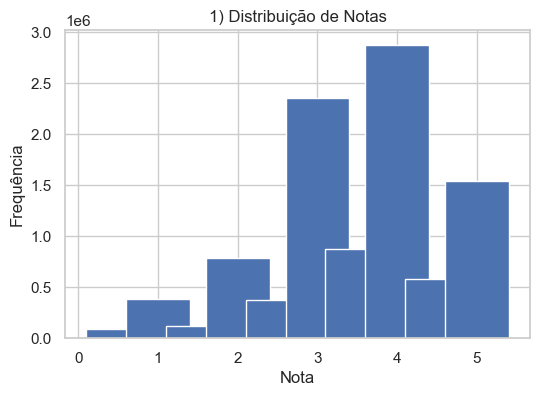


=== 2) Top 10 filmes mais avaliados ===
shape: (10, 2)
┌─────────────────────────────────┬───────────┐
│ title                           ┆ n_ratings │
│ ---                             ┆ ---       │
│ str                             ┆ i64       │
╞═════════════════════════════════╪═══════════╡
│ Pulp Fiction (1994)             ┆ 34864     │
│ Forrest Gump (1994)             ┆ 34457     │
│ Silence of the Lambs, The (199… ┆ 33668     │
│ Jurassic Park (1993)            ┆ 32631     │
│ Shawshank Redemption, The (199… ┆ 31126     │
│ Braveheart (1995)               ┆ 29154     │
│ Fugitive, The (1993)            ┆ 28951     │
│ Terminator 2: Judgment Day (19… ┆ 28948     │
│ Star Wars: Episode IV - A New … ┆ 28566     │
│ Apollo 13 (1995)                ┆ 27035     │
└─────────────────────────────────┴───────────┘


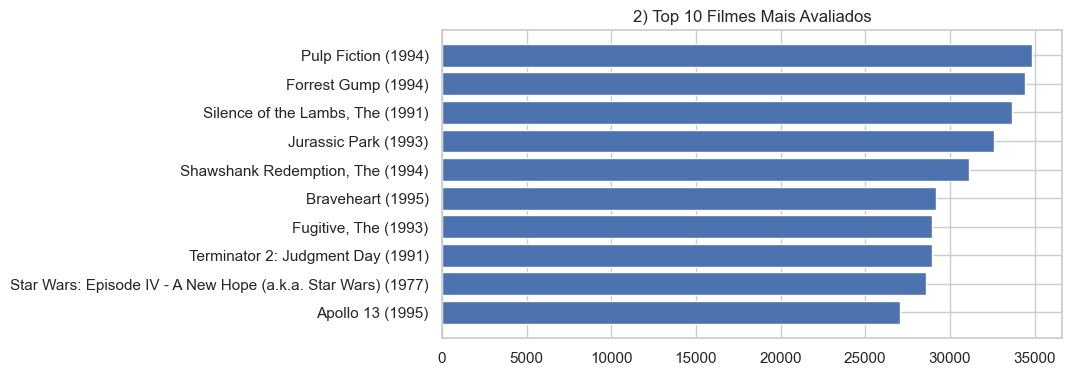


=== 3) Top 10 filmes com melhor média (≥100 avaliações) ===
shape: (10, 3)
┌─────────────────────────────────┬───────────┬────────────┐
│ title                           ┆ n_ratings ┆ avg_rating │
│ ---                             ┆ ---       ┆ ---        │
│ str                             ┆ i64       ┆ f64        │
╞═════════════════════════════════╪═══════════╪════════════╡
│ Shawshank Redemption, The (199… ┆ 31126     ┆ 4.457238   │
│ Godfather, The (1972)           ┆ 19814     ┆ 4.415085   │
│ Usual Suspects, The (1995)      ┆ 24037     ┆ 4.367142   │
│ Schindler's List (1993)         ┆ 25777     ┆ 4.363483   │
│ Sunset Blvd. (a.k.a. Sunset Bo… ┆ 3255      ┆ 4.321966   │
│ Casablanca (1942)               ┆ 12507     ┆ 4.319741   │
│ Rear Window (1954)              ┆ 8825      ┆ 4.316544   │
│ Double Indemnity (1944)         ┆ 2403      ┆ 4.315439   │
│ Seven Samurai (Shichinin no sa… ┆ 5751      ┆ 4.314119   │
│ Third Man, The (1949)           ┆ 3265      ┆ 4.313629   │
└────────

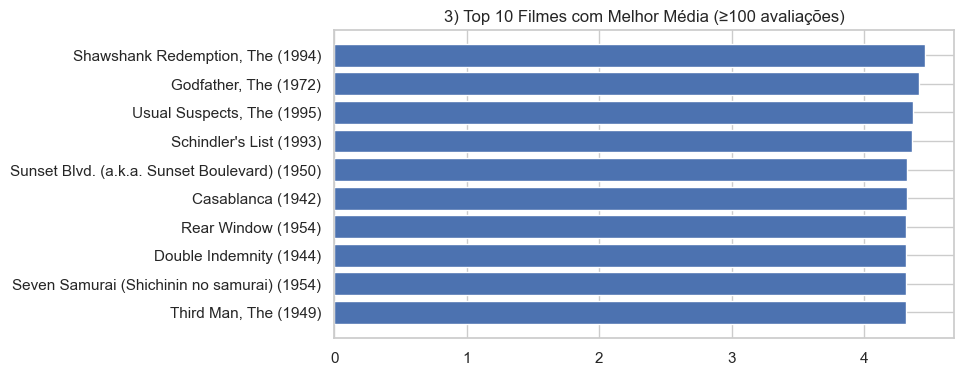


=== 4) Popularidade por gênero ===
shape: (19, 2)
┌───────────┬──────────┐
│ genre     ┆ n_movies │
│ ---       ┆ ---      │
│ str       ┆ i64      │
╞═══════════╪══════════╡
│ Drama     ┆ 5339     │
│ Comedy    ┆ 3703     │
│ Thriller  ┆ 1706     │
│ Romance   ┆ 1685     │
│ Action    ┆ 1473     │
│ …         ┆ …        │
│ Musical   ┆ 436      │
│ Animation ┆ 286      │
│ Western   ┆ 275      │
│ Film-Noir ┆ 148      │
│ IMAX      ┆ 29       │
└───────────┴──────────┘


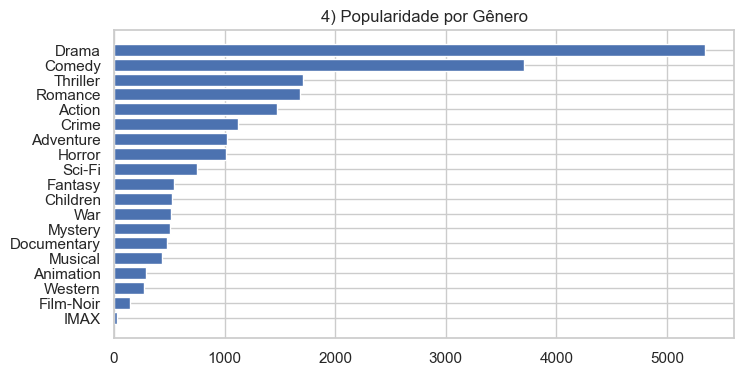


=== 5) Atividade de avaliações ao longo do tempo ===
shape: (12, 2)
┌─────────────────────────────┬───────────┐
│ month                       ┆ n_ratings │
│ ---                         ┆ ---       │
│ datetime[μs, Europe/London] ┆ i64       │
╞═════════════════════════════╪═══════════╡
│ 1995-01-01 00:00:00 GMT     ┆ 3         │
│ 1996-01-01 00:00:00 GMT     ┆ 21        │
│ 1996-02-01 00:00:00 GMT     ┆ 336       │
│ 1996-03-01 00:00:00 GMT     ┆ 6573      │
│ 1996-04-01 00:00:00 BST     ┆ 34944     │
│ …                           ┆ …         │
│ 1996-07-01 00:00:00 BST     ┆ 142567    │
│ 1996-08-01 00:00:00 BST     ┆ 142711    │
│ 1996-09-01 00:00:00 BST     ┆ 97533     │
│ 1996-10-01 00:00:00 BST     ┆ 125259    │
│ 1996-11-01 00:00:00 GMT     ┆ 118539    │
└─────────────────────────────┴───────────┘


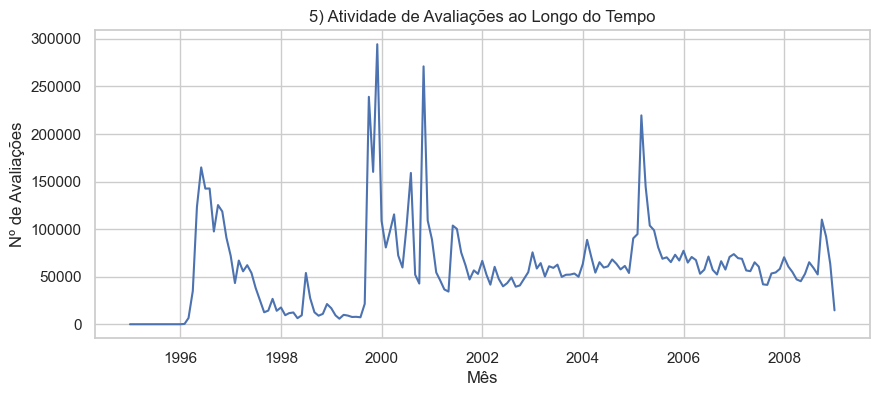


=== 6) Ciclo de vida por ano de lançamento ===
shape: (20, 2)
┌────────────┬───────────┐
│ year_guess ┆ n_ratings │
│ ---        ┆ ---       │
│ i32        ┆ i64       │
╞════════════╪═══════════╡
│ 1915       ┆ 203       │
│ 1916       ┆ 101       │
│ 1917       ┆ 36        │
│ 1918       ┆ 82        │
│ 1919       ┆ 183       │
│ …          ┆ …         │
│ 1930       ┆ 2758      │
│ 1931       ┆ 8483      │
│ 1932       ┆ 3604      │
│ 1933       ┆ 8527      │
│ 1934       ┆ 6600      │
└────────────┴───────────┘


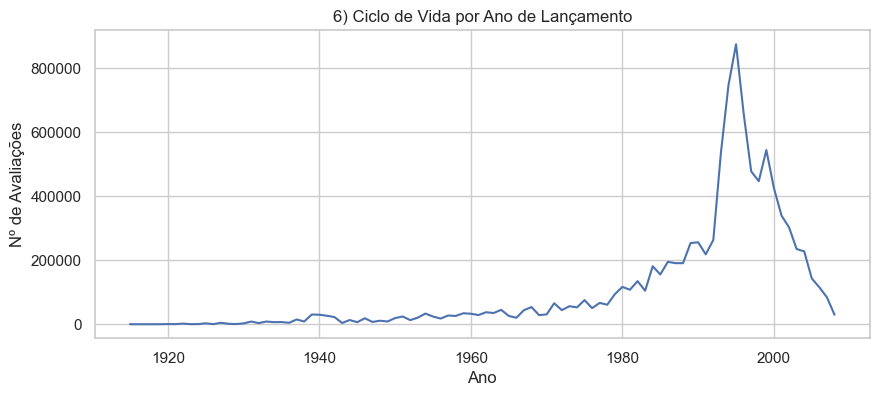


=== 7) Distribuição de avaliações por filme (long tail) ===
shape: (20, 2)
┌─────────┬───────────┐
│ movieId ┆ n_ratings │
│ ---     ┆ ---       │
│ i64     ┆ i64       │
╞═════════╪═══════════╡
│ 296     ┆ 34864     │
│ 356     ┆ 34457     │
│ 593     ┆ 33668     │
│ 480     ┆ 32631     │
│ 318     ┆ 31126     │
│ …       ┆ …         │
│ 380     ┆ 25381     │
│ 1210    ┆ 25098     │
│ 32      ┆ 24397     │
│ 50      ┆ 24037     │
│ 608     ┆ 23794     │
└─────────┴───────────┘


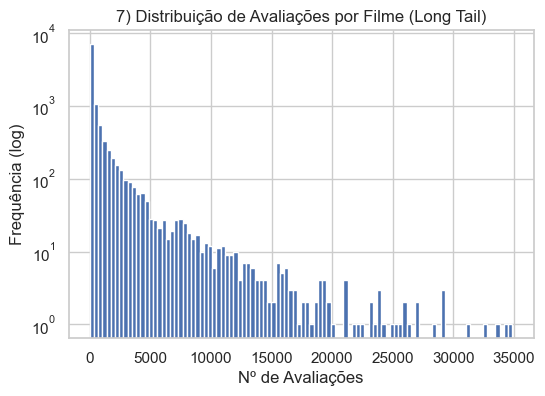


=== 8) Tags mais frequentes ===
shape: (20, 2)
┌───────────────────────┬──────┐
│ tag                   ┆ freq │
│ ---                   ┆ ---  │
│ str                   ┆ i64  │
╞═══════════════════════╪══════╡
│ classic               ┆ 718  │
│ tumey's dvds          ┆ 641  │
│ based on a book       ┆ 555  │
│ r                     ┆ 518  │
│ less than 300 ratings ┆ 505  │
│ …                     ┆ …    │
│ drama                 ┆ 349  │
│ movie to see          ┆ 345  │
│ disney                ┆ 335  │
│ imdb top 250          ┆ 318  │
│ world war ii          ┆ 315  │
└───────────────────────┴──────┘


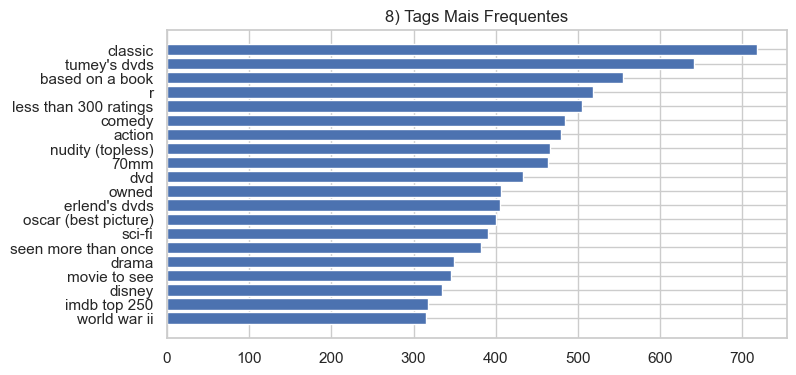


=== 9) Co-ocorrência de gêneros ===
shape: (20, 3)
┌───────────┬──────────┬──────┐
│ g1        ┆ g2       ┆ n    │
│ ---       ┆ ---      ┆ ---  │
│ str       ┆ str      ┆ i64  │
╞═══════════╪══════════╪══════╡
│ Comedy    ┆ Drama    ┆ 1081 │
│ Drama     ┆ Romance  ┆ 1006 │
│ Comedy    ┆ Romance  ┆ 847  │
│ Drama     ┆ Thriller ┆ 768  │
│ Crime     ┆ Drama    ┆ 638  │
│ …         ┆ …        ┆ …    │
│ Adventure ┆ Comedy   ┆ 282  │
│ Mystery   ┆ Thriller ┆ 277  │
│ Action    ┆ Sci-Fi   ┆ 270  │
│ Children  ┆ Comedy   ┆ 256  │
│ Drama     ┆ Mystery  ┆ 242  │
└───────────┴──────────┴──────┘


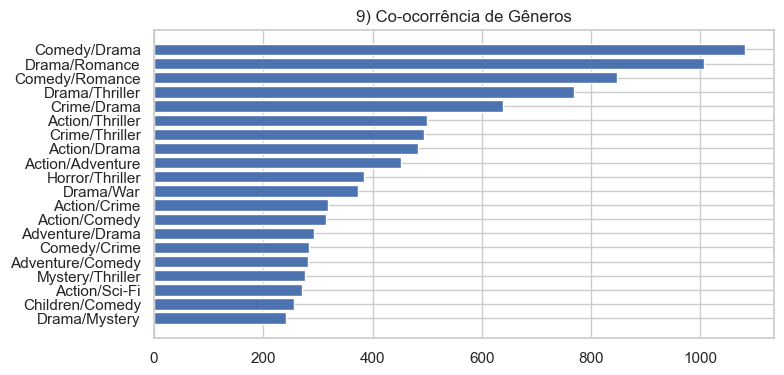


=== 10) Média global ===
shape: (1, 1)
┌──────────┐
│ gmean    │
│ ---      │
│ f64      │
╞══════════╡
│ 3.512422 │
└──────────┘


In [66]:
import os
import polars as pl
import matplotlib.pyplot as plt

# Função auxiliar
def q(sql: str) -> pl.DataFrame:
    return pl.from_arrow(con.execute(sql).arrow())

# Diretório de saída
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# 1) Distribuição de notas
stat1 = q("""
    SELECT rating::DOUBLE AS rating, COUNT(*) AS freq
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")
print("=== 1) Distribuição de notas ===")
print(stat1)
plt.figure(figsize=(6,4))
plt.bar(stat1["rating"], stat1["freq"])
plt.title("1) Distribuição de Notas")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.savefig(os.path.join(output_dir, "01_distribuicao_notas.png"))
plt.show()

# 2) Top 10 filmes mais avaliados
stat2 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 10
""")
print("\n=== 2) Top 10 filmes mais avaliados ===")
print(stat2)
plt.figure(figsize=(8,4))
plt.barh(stat2["title"], stat2["n_ratings"])
plt.title("2) Top 10 Filmes Mais Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "02_top10_filmes.png"))
plt.show()

# 3) Top 10 filmes com melhor média (≥100 avaliações)
stat3 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 10
""")
print("\n=== 3) Top 10 filmes com melhor média (≥100 avaliações) ===")
print(stat3)
plt.figure(figsize=(8,4))
plt.barh(stat3["title"], stat3["avg_rating"])
plt.title("3) Top 10 Filmes com Melhor Média (≥100 avaliações)")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "03_top10_melhor_media.png"))
plt.show()

# 4) Popularidade por gênero
stat4 = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    SELECT genre, COUNT(*) AS n_movies
    FROM exploded
    GROUP BY genre
    ORDER BY n_movies DESC
""")
print("\n=== 4) Popularidade por gênero ===")
print(stat4)
plt.figure(figsize=(8,4))
plt.barh(stat4["genre"], stat4["n_movies"])
plt.title("4) Popularidade por Gênero")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "04_popularidade_genero.png"))
plt.show()

# 5) Atividade de avaliações ao longo do tempo (mensal)
stat5 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 5) Atividade de avaliações ao longo do tempo ===")
print(stat5.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat5["month"], stat5["n_ratings"])
plt.title("5) Atividade de Avaliações ao Longo do Tempo")
plt.xlabel("Mês")
plt.ylabel("Nº de Avaliações")
plt.savefig(os.path.join(output_dir, "05_avaliacoes_tempo.png"))
plt.show()

# 6) Ciclo de vida por ano de lançamento
stat6 = q("""
    SELECT CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) AS year_guess,
           COUNT(r.rating) AS n_ratings
    FROM movies m
    LEFT JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
      AND TRY_CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) IS NOT NULL
    GROUP BY year_guess
    ORDER BY year_guess
""")
print("\n=== 6) Ciclo de vida por ano de lançamento ===")
print(stat6.head(20))
plt.figure(figsize=(10,4))
plt.plot(stat6["year_guess"], stat6["n_ratings"])
plt.title("6) Ciclo de Vida por Ano de Lançamento")
plt.xlabel("Ano")
plt.ylabel("Nº de Avaliações")
plt.savefig(os.path.join(output_dir, "06_ciclo_vida.png"))
plt.show()

# 7) Atividade por filme (long tail)
stat7 = q("""
    SELECT movieId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")
print("\n=== 7) Distribuição de avaliações por filme (long tail) ===")
print(stat7.head(20))
plt.figure(figsize=(6,4))
plt.hist(stat7["n_ratings"], bins=100, log=True)
plt.title("7) Distribuição de Avaliações por Filme (Long Tail)")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Frequência (log)")
plt.savefig(os.path.join(output_dir, "07_long_tail.png"))
plt.show()

# 8) Tags mais frequentes
stat8 = q("""
    SELECT LOWER(TRIM(tag)) AS tag, COUNT(*) AS freq
    FROM tags
    WHERE tag IS NOT NULL AND TRIM(tag) <> ''
    GROUP BY LOWER(TRIM(tag))
    ORDER BY freq DESC
    LIMIT 20
""")
print("\n=== 8) Tags mais frequentes ===")
print(stat8)
plt.figure(figsize=(8,4))
plt.barh(stat8["tag"], stat8["freq"])
plt.title("8) Tags Mais Frequentes")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "08_tags_frequentes.png"))
plt.show()

# 9) Co-ocorrência de gêneros
stat9 = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    ),
    pairs AS (
        SELECT a.movieId, LEAST(a.genre,b.genre) AS g1, GREATEST(a.genre,b.genre) AS g2
        FROM exploded a
        JOIN exploded b ON a.movieId = b.movieId AND a.genre < b.genre
    )
    SELECT g1, g2, COUNT(*) AS n
    FROM pairs
    GROUP BY g1, g2
    ORDER BY n DESC
    LIMIT 20
""")
print("\n=== 9) Co-ocorrência de gêneros ===")
print(stat9)
plt.figure(figsize=(8,4))
plt.barh([f"{g1}/{g2}" for g1,g2 in zip(stat9["g1"], stat9["g2"])], stat9["n"])
plt.title("9) Co-ocorrência de Gêneros")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "09_coocorrencia_generos.png"))
plt.show()

# 10) Média global
stat10 = q("SELECT AVG(rating) AS gmean FROM ratings")
print("\n=== 10) Média global ===")
print(stat10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

=== 11) Distribuição de nº de avaliações por usuário ===
shape: (9, 3)
┌────────────┬──────────────┬───────────┐
│ statistic  ┆ userId       ┆ n_ratings │
│ ---        ┆ ---          ┆ ---       │
│ str        ┆ f64          ┆ f64       │
╞════════════╪══════════════╪═══════════╡
│ count      ┆ 69878.0      ┆ 69878.0   │
│ null_count ┆ 0.0          ┆ 0.0       │
│ mean       ┆ 35782.217393 ┆ 143.10733 │
│ std        ┆ 20613.909098 ┆ 216.71258 │
│ min        ┆ 1.0          ┆ 20.0      │
│ 25%        ┆ 17943.0      ┆ 35.0      │
│ 50%        ┆ 35799.0      ┆ 69.0      │
│ 75%        ┆ 53620.0      ┆ 156.0     │
│ max        ┆ 71567.0      ┆ 7359.0    │
└────────────┴──────────────┴───────────┘


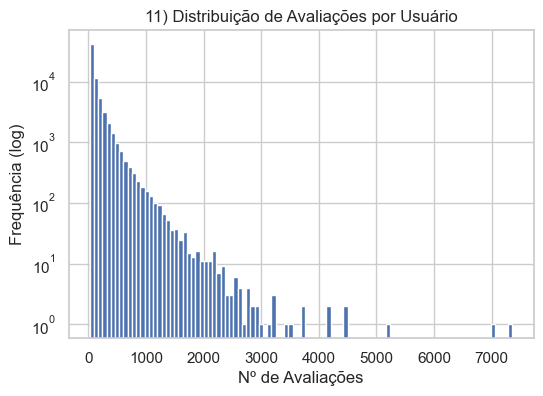


=== 12) Distribuição da média de notas por usuário ===
shape: (9, 3)
┌────────────┬──────────────┬────────────┐
│ statistic  ┆ userId       ┆ avg_rating │
│ ---        ┆ ---          ┆ ---        │
│ str        ┆ f64          ┆ f64        │
╞════════════╪══════════════╪════════════╡
│ count      ┆ 69878.0      ┆ 69878.0    │
│ null_count ┆ 0.0          ┆ 0.0        │
│ mean       ┆ 35782.217393 ┆ 3.613641   │
│ std        ┆ 20613.909098 ┆ 0.428244   │
│ min        ┆ 1.0          ┆ 0.5        │
│ 25%        ┆ 17943.0      ┆ 3.36       │
│ 50%        ┆ 35799.0      ┆ 3.634615   │
│ 75%        ┆ 53620.0      ┆ 3.9        │
│ max        ┆ 71567.0      ┆ 5.0        │
└────────────┴──────────────┴────────────┘


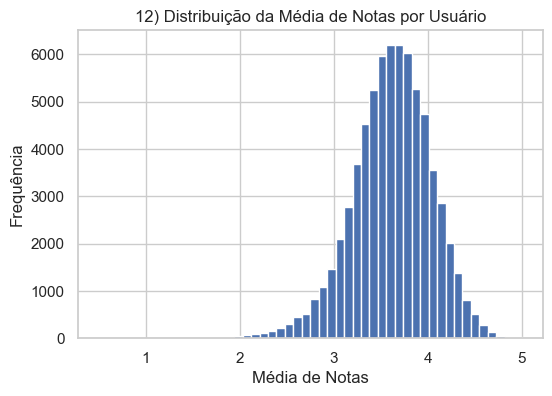


=== 13) Top 20 usuários mais ativos ===
shape: (20, 2)
┌────────┬───────────┐
│ userId ┆ n_ratings │
│ ---    ┆ ---       │
│ i64    ┆ i64       │
╞════════╪═══════════╡
│ 59269  ┆ 7359      │
│ 67385  ┆ 7047      │
│ 14463  ┆ 5169      │
│ 68259  ┆ 4483      │
│ 27468  ┆ 4449      │
│ …      ┆ …         │
│ 30723  ┆ 3027      │
│ 30687  ┆ 2909      │
│ 31327  ┆ 2886      │
│ 30500  ┆ 2827      │
│ 47046  ┆ 2812      │
└────────┴───────────┘


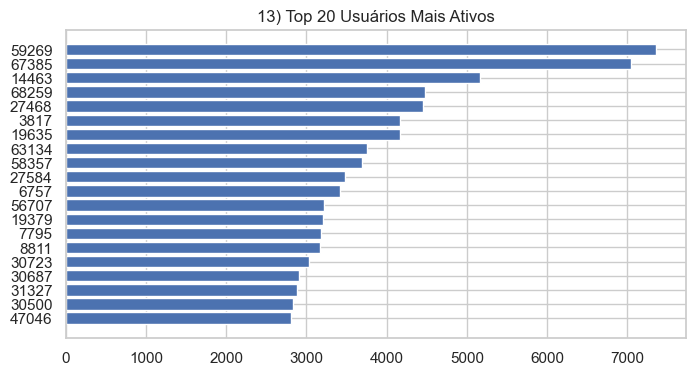


=== 14) Média de notas por gênero ===
shape: (19, 2)
┌─────────────┬────────────┐
│ genre       ┆ avg_rating │
│ ---         ┆ ---        │
│ str         ┆ f64        │
╞═════════════╪════════════╡
│ Film-Noir   ┆ 4.012151   │
│ Documentary ┆ 3.783459   │
│ War         ┆ 3.780173   │
│ IMAX        ┆ 3.764537   │
│ Mystery     ┆ 3.677631   │
│ …           ┆ …          │
│ Comedy      ┆ 3.436946   │
│ Action      ┆ 3.421331   │
│ Children    ┆ 3.418474   │
│ Sci-Fi      ┆ 3.396193   │
│ Horror      ┆ 3.269243   │
└─────────────┴────────────┘


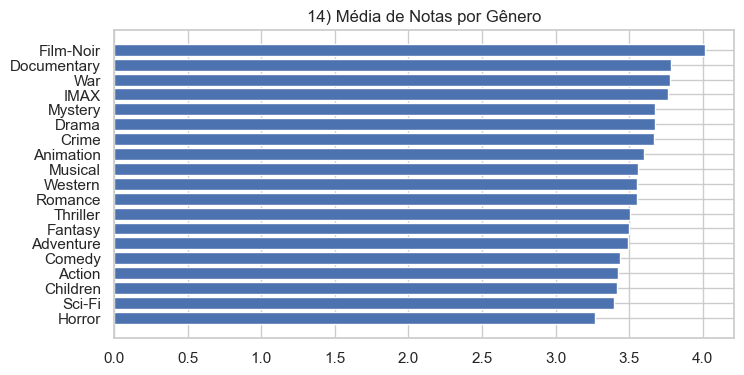


=== 15) Usuários únicos por mês ===
shape: (12, 2)
┌─────────────────────────────┬─────────┐
│ month                       ┆ n_users │
│ ---                         ┆ ---     │
│ datetime[μs, Europe/London] ┆ i64     │
╞═════════════════════════════╪═════════╡
│ 1995-01-01 00:00:00 GMT     ┆ 1       │
│ 1996-01-01 00:00:00 GMT     ┆ 4       │
│ 1996-02-01 00:00:00 GMT     ┆ 17      │
│ 1996-03-01 00:00:00 GMT     ┆ 162     │
│ 1996-04-01 00:00:00 BST     ┆ 838     │
│ …                           ┆ …       │
│ 1996-07-01 00:00:00 BST     ┆ 2806    │
│ 1996-08-01 00:00:00 BST     ┆ 2784    │
│ 1996-09-01 00:00:00 BST     ┆ 2119    │
│ 1996-10-01 00:00:00 BST     ┆ 2591    │
│ 1996-11-01 00:00:00 GMT     ┆ 2359    │
└─────────────────────────────┴─────────┘


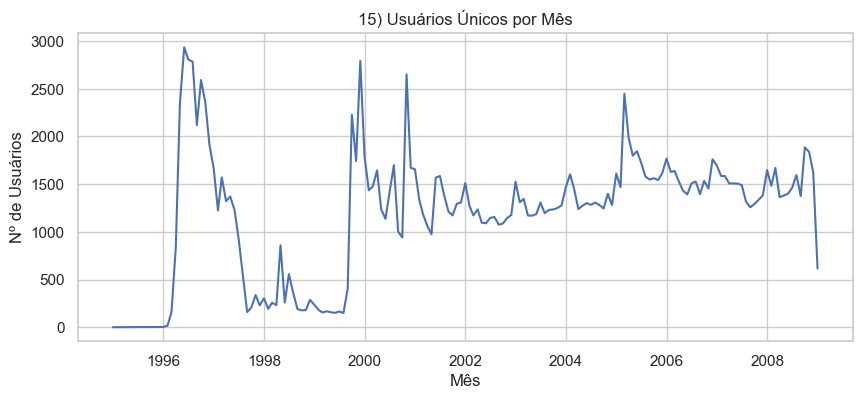

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 16) Filmes distintos avaliados por mês ===
shape: (12, 2)
┌─────────────────────────────┬──────────┐
│ month                       ┆ n_movies │
│ ---                         ┆ ---      │
│ datetime[μs, Europe/London] ┆ i64      │
╞═════════════════════════════╪══════════╡
│ 1995-01-01 00:00:00 GMT     ┆ 3        │
│ 1996-01-01 00:00:00 GMT     ┆ 15       │
│ 1996-02-01 00:00:00 GMT     ┆ 101      │
│ 1996-03-01 00:00:00 GMT     ┆ 447      │
│ 1996-04-01 00:00:00 BST     ┆ 416      │
│ …                           ┆ …        │
│ 1996-07-01 00:00:00 BST     ┆ 662      │
│ 1996-08-01 00:00:00 BST     ┆ 821      │
│ 1996-09-01 00:00:00 BST     ┆ 818      │
│ 1996-10-01 00:00:00 BST     ┆ 1178     │
│ 1996-11-01 00:00:00 GMT     ┆ 1224     │
└─────────────────────────────┴──────────┘


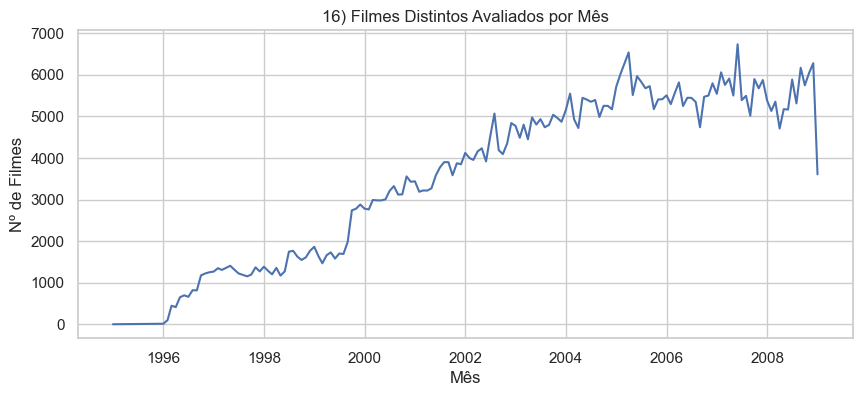


=== 17) Relação nº de avaliações x média do filme (top 20) ===
shape: (20, 3)
┌─────────────────────────────────┬───────────┬────────────┐
│ title                           ┆ n_ratings ┆ avg_rating │
│ ---                             ┆ ---       ┆ ---        │
│ str                             ┆ i64       ┆ f64        │
╞═════════════════════════════════╪═══════════╪════════════╡
│ Pulp Fiction (1994)             ┆ 34864     ┆ 4.157426   │
│ Forrest Gump (1994)             ┆ 34457     ┆ 4.013582   │
│ Silence of the Lambs, The (199… ┆ 33668     ┆ 4.2042     │
│ Jurassic Park (1993)            ┆ 32631     ┆ 3.661564   │
│ Shawshank Redemption, The (199… ┆ 31126     ┆ 4.457238   │
│ …                               ┆ …         ┆ …          │
│ True Lies (1994)                ┆ 25381     ┆ 3.500315   │
│ Star Wars: Episode VI - Return… ┆ 25098     ┆ 3.996354   │
│ 12 Monkeys (Twelve Monkeys) (1… ┆ 24397     ┆ 3.875067   │
│ Usual Suspects, The (1995)      ┆ 24037     ┆ 4.367142   │
│ Farg

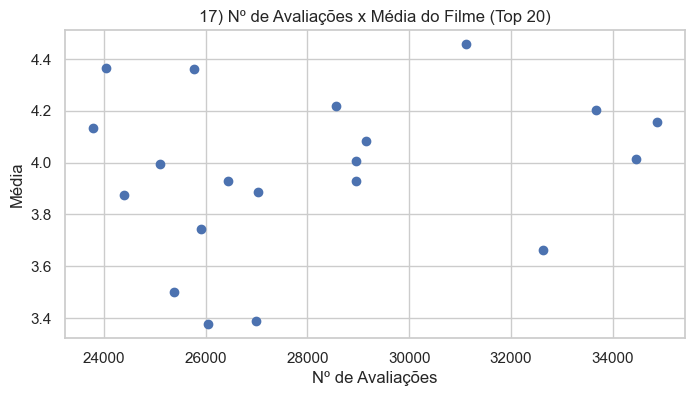


=== 18) Distribuição de avaliações por hora ===
shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ n_ratings │
│ ---  ┆ ---       │
│ i64  ┆ i64       │
╞══════╪═══════════╡
│ 0    ┆ 474841    │
│ 1    ┆ 451974    │
│ 2    ┆ 428121    │
│ 3    ┆ 433471    │
│ 4    ┆ 416928    │
│ …    ┆ …         │
│ 19   ┆ 571961    │
│ 20   ┆ 571946    │
│ 21   ┆ 591953    │
│ 22   ┆ 567737    │
│ 23   ┆ 507400    │
└──────┴───────────┘


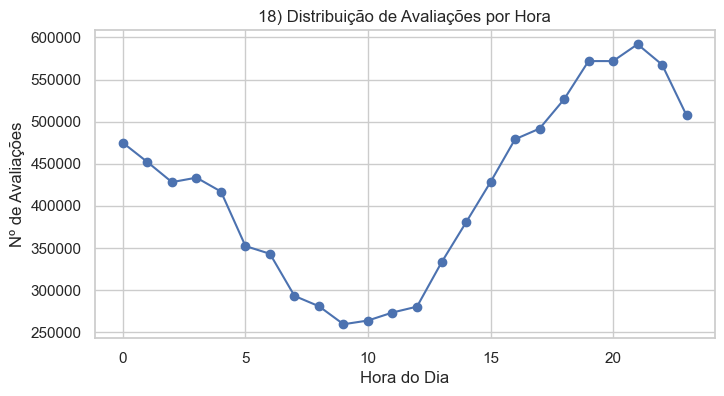


=== 19) Distribuição de avaliações por dia da semana ===
shape: (7, 2)
┌─────┬───────────┐
│ dow ┆ n_ratings │
│ --- ┆ ---       │
│ i64 ┆ i64       │
╞═════╪═══════════╡
│ 0   ┆ 1363969   │
│ 1   ┆ 1561492   │
│ 2   ┆ 1596147   │
│ 3   ┆ 1479151   │
│ 4   ┆ 1381722   │
│ 5   ┆ 1366327   │
│ 6   ┆ 1251246   │
└─────┴───────────┘


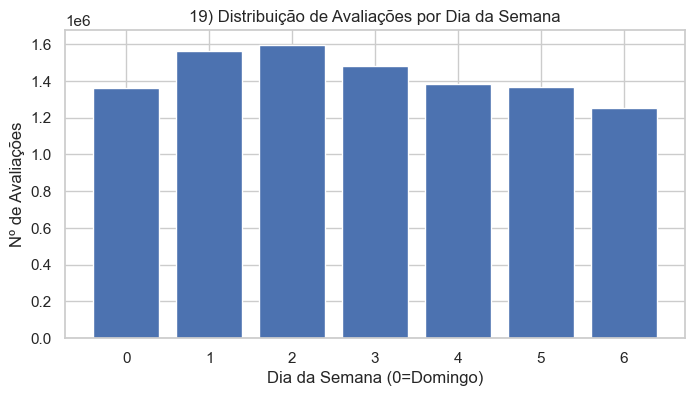


=== 20) Filmes mais polarizadores ===
shape: (15, 3)
┌─────────────────────────────────┬───────┬──────────┐
│ title                           ┆ n     ┆ std      │
│ ---                             ┆ ---   ┆ ---      │
│ str                             ┆ i64   ┆ f64      │
╞═════════════════════════════════╪═══════╪══════════╡
│ Plan 9 from Outer Space (1959)  ┆ 1368  ┆ 1.408317 │
│ Passion of the Christ, The (20… ┆ 1600  ┆ 1.351458 │
│ Stupids, The (1996)             ┆ 678   ┆ 1.326324 │
│ Children of the Corn IV: The G… ┆ 570   ┆ 1.32028  │
│ Texas Chainsaw Massacre, The (… ┆ 1587  ┆ 1.297798 │
│ …                               ┆ …     ┆ …        │
│ Crash (1996)                    ┆ 1448  ┆ 1.260912 │
│ Postman, The (1997)             ┆ 1028  ┆ 1.253114 │
│ Blair Witch Project, The (1999… ┆ 10593 ┆ 1.249343 │
│ Booty Call (1997)               ┆ 696   ┆ 1.248837 │
│ Babe: Pig in the City (1998)    ┆ 2788  ┆ 1.233428 │
└─────────────────────────────────┴───────┴──────────┘


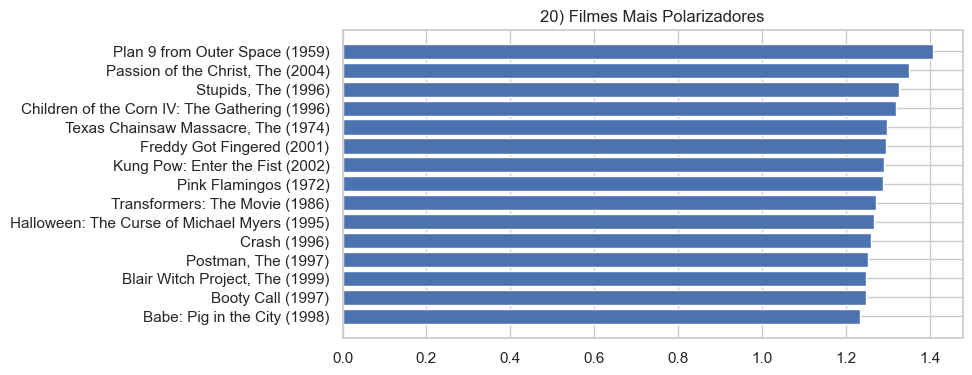

In [67]:
# 11) Distribuição de nº de avaliações por usuário
stat11 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
""")
print("=== 11) Distribuição de nº de avaliações por usuário ===")
print(stat11.describe())
plt.figure(figsize=(6,4))
plt.hist(stat11["n_ratings"], bins=100, log=True)
plt.title("11) Distribuição de Avaliações por Usuário")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Frequência (log)")
plt.savefig(os.path.join(output_dir, "11_avaliacoes_usuario.png"))
plt.show()

# 12) Distribuição da média de notas por usuário
stat12 = q("""
    SELECT userId, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY userId
""")
print("\n=== 12) Distribuição da média de notas por usuário ===")
print(stat12.describe())
plt.figure(figsize=(6,4))
plt.hist(stat12["avg_rating"], bins=50)
plt.title("12) Distribuição da Média de Notas por Usuário")
plt.xlabel("Média de Notas")
plt.ylabel("Frequência")
plt.savefig(os.path.join(output_dir, "12_media_usuario.png"))
plt.show()

# 13) Top 20 usuários mais ativos
stat13 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
    ORDER BY n_ratings DESC
    LIMIT 20
""")
print("\n=== 13) Top 20 usuários mais ativos ===")
print(stat13)
plt.figure(figsize=(8,4))
plt.barh(stat13["userId"].cast(str), stat13["n_ratings"])
plt.title("13) Top 20 Usuários Mais Ativos")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "13_top20_usuarios.png"))
plt.show()

# 14) Notas por gênero (média)
stat14 = q("""
    WITH exploded AS (
        SELECT r.rating, UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT genre, AVG(rating) AS avg_rating
    FROM exploded
    GROUP BY genre
    ORDER BY avg_rating DESC
""")
print("\n=== 14) Média de notas por gênero ===")
print(stat14)
plt.figure(figsize=(8,4))
plt.barh(stat14["genre"], stat14["avg_rating"])
plt.title("14) Média de Notas por Gênero")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "14_media_genero.png"))
plt.show()

# 15) Usuários únicos por mês
stat15 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT userId) AS n_users
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 15) Usuários únicos por mês ===")
print(stat15.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat15["month"], stat15["n_users"])
plt.title("15) Usuários Únicos por Mês")
plt.xlabel("Mês")
plt.ylabel("Nº de Usuários")
plt.savefig(os.path.join(output_dir, "15_usuarios_mes.png"))
plt.show()

# 16) Filmes distintos avaliados por mês
stat16 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT movieId) AS n_movies
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 16) Filmes distintos avaliados por mês ===")
print(stat16.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat16["month"], stat16["n_movies"])
plt.title("16) Filmes Distintos Avaliados por Mês")
plt.xlabel("Mês")
plt.ylabel("Nº de Filmes")
plt.savefig(os.path.join(output_dir, "16_filmes_mes.png"))
plt.show()

# 17) Relação nº de avaliações x média do filme (top 20)
stat17 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 20
""")
print("\n=== 17) Relação nº de avaliações x média do filme (top 20) ===")
print(stat17)
plt.figure(figsize=(8,4))
plt.scatter(stat17["n_ratings"], stat17["avg_rating"])
plt.title("17) Nº de Avaliações x Média do Filme (Top 20)")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Média")
plt.savefig(os.path.join(output_dir, "17_avaliacoes_vs_media.png"))
plt.show()

# 18) Distribuição de avaliações por hora
stat18 = q("""
    SELECT EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY hour
    ORDER BY hour
""")
print("\n=== 18) Distribuição de avaliações por hora ===")
print(stat18)
plt.figure(figsize=(8,4))
plt.plot(stat18["hour"], stat18["n_ratings"], marker="o")
plt.title("18) Distribuição de Avaliações por Hora")
plt.xlabel("Hora do Dia")
plt.ylabel("Nº de Avaliações")
plt.savefig(os.path.join(output_dir, "18_avaliacoes_hora.png"))
plt.show()

# 19) Distribuição de avaliações por dia da semana
stat19 = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY dow
    ORDER BY dow
""")
print("\n=== 19) Distribuição de avaliações por dia da semana ===")
print(stat19)
plt.figure(figsize=(8,4))
plt.bar(stat19["dow"], stat19["n_ratings"])
plt.title("19) Distribuição de Avaliações por Dia da Semana")
plt.xlabel("Dia da Semana (0=Domingo)")
plt.ylabel("Nº de Avaliações")
plt.savefig(os.path.join(output_dir, "19_avaliacoes_semana.png"))
plt.show()

# 20) Filmes mais polarizadores (maior desvio padrão)
stat20 = q("""
    SELECT m.title, COUNT(r.rating) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 500
    ORDER BY std DESC
    LIMIT 15
""")
print("\n=== 20) Filmes mais polarizadores ===")
print(stat20)
plt.figure(figsize=(8,4))
plt.barh(stat20["title"], stat20["std"])
plt.title("20) Filmes Mais Polarizadores")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "20_filmes_polarizadores.png"))
plt.show()

=== 21) Filmes mais consensuais ===
shape: (15, 3)
┌─────────────────────────────────┬──────┬──────────┐
│ title                           ┆ n    ┆ std      │
│ ---                             ┆ ---  ┆ ---      │
│ str                             ┆ i64  ┆ f64      │
╞═════════════════════════════════╪══════╪══════════╡
│ Gone Baby Gone (2007)           ┆ 734  ┆ 0.641226 │
│ Last King of Scotland, The (20… ┆ 1281 ┆ 0.644991 │
│ Touching the Void (2003)        ┆ 888  ┆ 0.65028  │
│ Bank Job, The (2008)            ┆ 605  ┆ 0.657802 │
│ Murder on the Orient Express (… ┆ 538  ┆ 0.664082 │
│ …                               ┆ …    ┆ …        │
│ Good bye, Lenin! (2003)         ┆ 1662 ┆ 0.672287 │
│ Hotel Rwanda (2004)             ┆ 3181 ┆ 0.672562 │
│ Inside Man (2006)               ┆ 1959 ┆ 0.673569 │
│ Day of the Jackal, The (1973)   ┆ 807  ┆ 0.675559 │
│ Presumed Innocent (1990)        ┆ 618  ┆ 0.677258 │
└─────────────────────────────────┴──────┴──────────┘


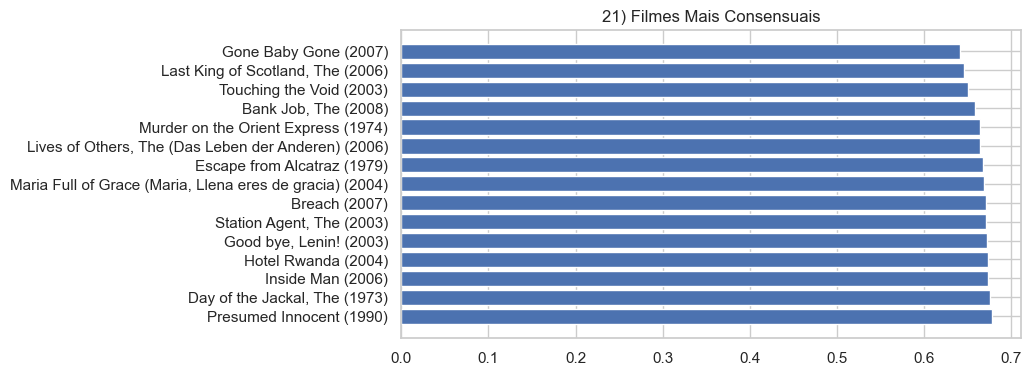


=== 22) Nº de tags por usuário ===
shape: (9, 3)
┌────────────┬──────────────┬───────────┐
│ statistic  ┆ userId       ┆ n_tags    │
│ ---        ┆ ---          ┆ ---       │
│ str        ┆ f64          ┆ f64       │
╞════════════╪══════════════╪═══════════╡
│ count      ┆ 4009.0       ┆ 4009.0    │
│ null_count ┆ 0.0          ┆ 0.0       │
│ mean       ┆ 35830.423298 ┆ 23.841357 │
│ std        ┆ 21481.275621 ┆ 179.68054 │
│ min        ┆ 15.0         ┆ 1.0       │
│ 25%        ┆ 17239.0      ┆ 1.0       │
│ 50%        ┆ 35438.0      ┆ 2.0       │
│ 75%        ┆ 54980.0      ┆ 7.0       │
│ max        ┆ 71556.0      ┆ 6012.0    │
└────────────┴──────────────┴───────────┘


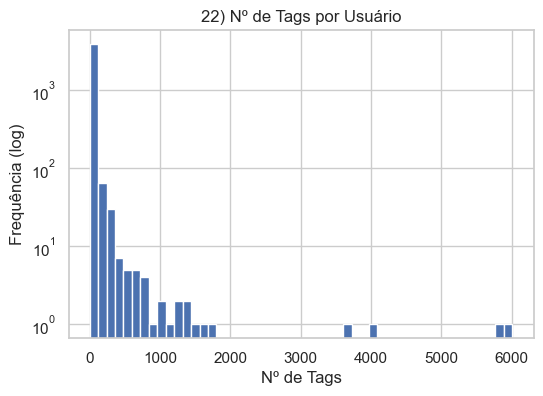

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 23) Tags mais associadas a notas altas ===
shape: (20, 3)
┌─────────────────────┬────────────┬─────┐
│ tag                 ┆ avg_rating ┆ n   │
│ ---                 ┆ ---        ┆ --- │
│ str                 ┆ f64        ┆ i64 │
╞═════════════════════╪════════════╪═════╡
│ need to own         ┆ 4.571429   ┆ 91  │
│ studio ghibli       ┆ 4.526786   ┆ 56  │
│ classic             ┆ 4.49       ┆ 50  │
│ classic             ┆ 4.43674    ┆ 411 │
│ hilarious           ┆ 4.376712   ┆ 73  │
│ …                   ┆ …          ┆ …   │
│ seen more than once ┆ 4.195652   ┆ 230 │
│ drama               ┆ 4.195652   ┆ 69  │
│ comedy              ┆ 4.193878   ┆ 147 │
│ surreal             ┆ 4.189815   ┆ 108 │
│ adventure           ┆ 4.171429   ┆ 70  │
└─────────────────────┴────────────┴─────┘


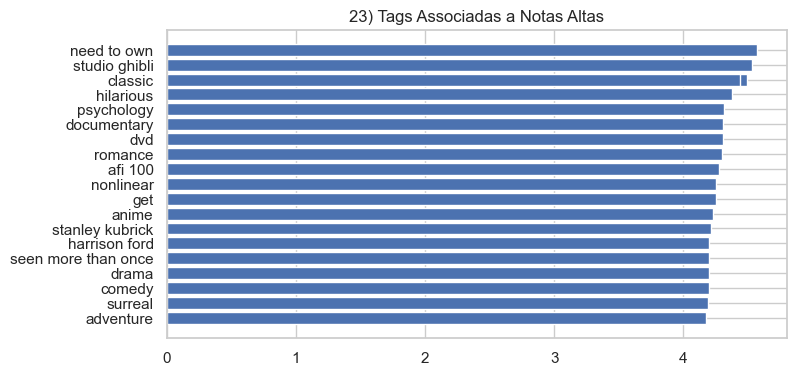


=== 24) Tags mais associadas a notas baixas ===
shape: (20, 3)
┌───────────────────┬────────────┬─────┐
│ tag               ┆ avg_rating ┆ n   │
│ ---               ┆ ---        ┆ --- │
│ str               ┆ f64        ┆ i64 │
╞═══════════════════╪════════════╪═════╡
│ boring            ┆ 1.588235   ┆ 119 │
│ stupid            ┆ 1.675926   ┆ 54  │
│ overrated         ┆ 2.483871   ┆ 124 │
│ violent           ┆ 2.611111   ┆ 54  │
│ afternoon section ┆ 2.676471   ┆ 51  │
│ …                 ┆ …          ┆ …   │
│ nudity (topless)  ┆ 3.003268   ┆ 153 │
│ cynical           ┆ 3.029412   ┆ 51  │
│ stylized          ┆ 3.05       ┆ 130 │
│ atmospheric       ┆ 3.058065   ┆ 155 │
│ ummarti2006       ┆ 3.067797   ┆ 59  │
└───────────────────┴────────────┴─────┘


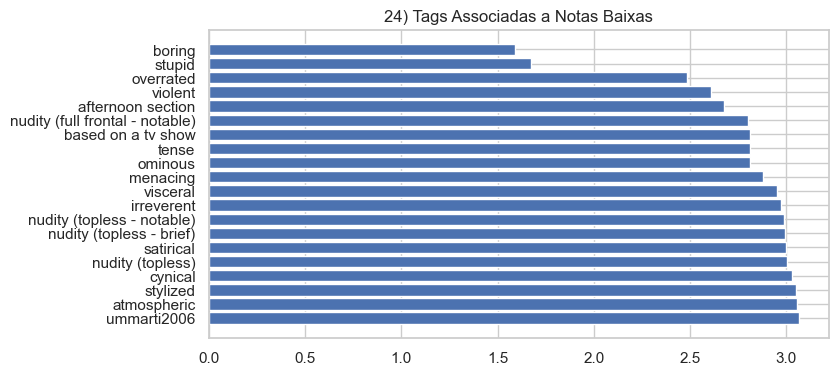

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 25) Evolução da nota média por gênero (amostra) ===
shape: (20, 3)
┌─────────────────────────────┬───────────┬────────────┐
│ year                        ┆ genre     ┆ avg_rating │
│ ---                         ┆ ---       ┆ ---        │
│ datetime[μs, Europe/London] ┆ str       ┆ f64        │
╞═════════════════════════════╪═══════════╪════════════╡
│ 1995-01-01 00:00:00 GMT     ┆ Action    ┆ 3.0        │
│ 1995-01-01 00:00:00 GMT     ┆ Comedy    ┆ 3.0        │
│ 1995-01-01 00:00:00 GMT     ┆ Crime     ┆ 4.0        │
│ 1995-01-01 00:00:00 GMT     ┆ Drama     ┆ 3.0        │
│ 1995-01-01 00:00:00 GMT     ┆ Horror    ┆ 5.0        │
│ …                           ┆ …         ┆ …          │
│ 1996-01-01 00:00:00 GMT     ┆ Fantasy   ┆ 3.53149    │
│ 1996-01-01 00:00:00 GMT     ┆ Film-Noir ┆ 3.677307   │
│ 1996-01-01 00:00:00 GMT     ┆ Horror    ┆ 3.59911    │
│ 1996-01-01 00:00:00 GMT     ┆ IMAX      ┆ 3.625      │
│ 1996-01-01 00:00:00 GMT     ┆ Musical   ┆ 3.63146    │
└───────────────

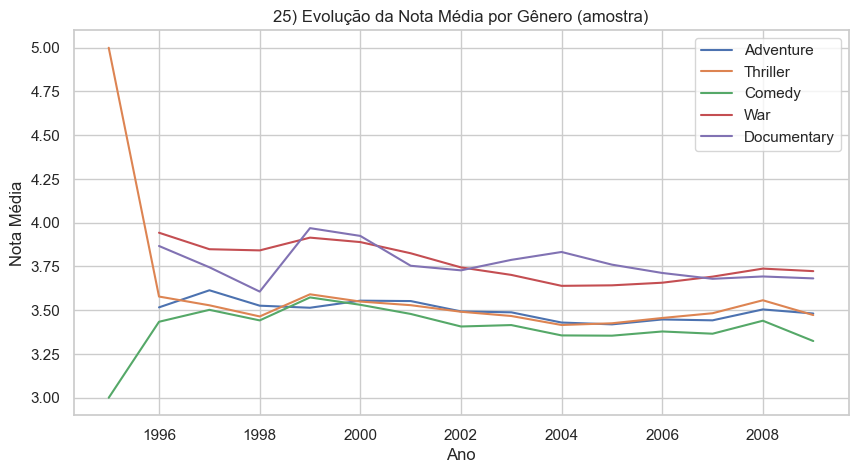


=== 26) Clássicos antigos mais bem avaliados ===
shape: (15, 3)
┌─────────────────────────────────┬────────────┬───────┐
│ title                           ┆ avg_rating ┆ n     │
│ ---                             ┆ ---        ┆ ---   │
│ str                             ┆ f64        ┆ i64   │
╞═════════════════════════════════╪════════════╪═══════╡
│ Sunset Blvd. (a.k.a. Sunset Bo… ┆ 4.321966   ┆ 3255  │
│ Casablanca (1942)               ┆ 4.319741   ┆ 12507 │
│ Rear Window (1954)              ┆ 4.316544   ┆ 8825  │
│ Double Indemnity (1944)         ┆ 4.315439   ┆ 2403  │
│ Seven Samurai (Shichinin no sa… ┆ 4.314119   ┆ 5751  │
│ …                               ┆ …          ┆ …     │
│ General, The (1927)             ┆ 4.257644   ┆ 1112  │
│ Rashomon (Rashômon) (1950)      ┆ 4.248272   ┆ 1591  │
│ All About Eve (1950)            ┆ 4.243676   ┆ 2530  │
│ Maltese Falcon, The (1941)      ┆ 4.242278   ┆ 6637  │
│ 12 Angry Men (1957)             ┆ 4.238117   ┆ 5365  │
└──────────────────────

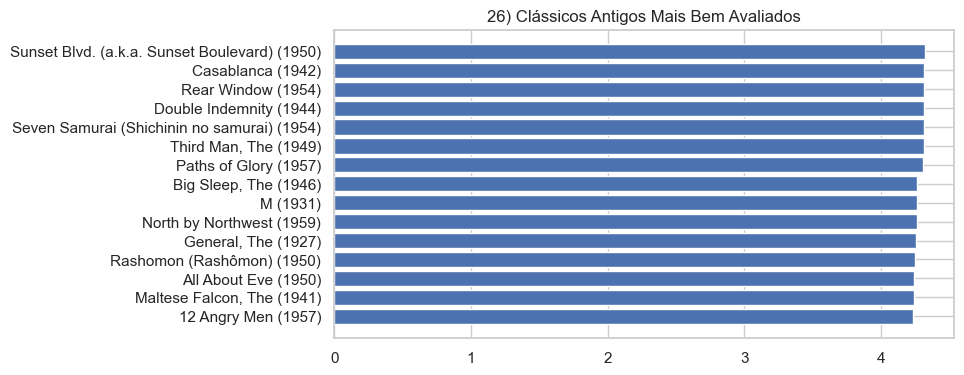


=== 27) Filmes recentes mais bem avaliados ===
shape: (15, 3)
┌─────────────────────────────────┬────────────┬───────┐
│ title                           ┆ avg_rating ┆ n     │
│ ---                             ┆ ---        ┆ ---   │
│ str                             ┆ f64        ┆ i64   │
╞═════════════════════════════════╪════════════╪═══════╡
│ Lives of Others, The (Das Lebe… ┆ 4.297154   ┆ 1230  │
│ Dark Knight, The (2008)         ┆ 4.294842   ┆ 2598  │
│ City of God (Cidade de Deus) (… ┆ 4.261899   ┆ 4370  │
│ Amelie (Fabuleux destin d'Amél… ┆ 4.246875   ┆ 9681  │
│ Memento (2000)                  ┆ 4.209332   ┆ 12891 │
│ …                               ┆ …          ┆ …     │
│ Eternal Sunshine of the Spotle… ┆ 4.130525   ┆ 8393  │
│ Fog of War: Eleven Lessons fro… ┆ 4.124893   ┆ 1173  │
│ Best of Youth, The (La Meglio … ┆ 4.122642   ┆ 159   │
│ Lord of the Rings: The Two Tow… ┆ 4.120404   ┆ 14389 │
│ Hotel Rwanda (2004)             ┆ 4.106099   ┆ 3181  │
└────────────────────────

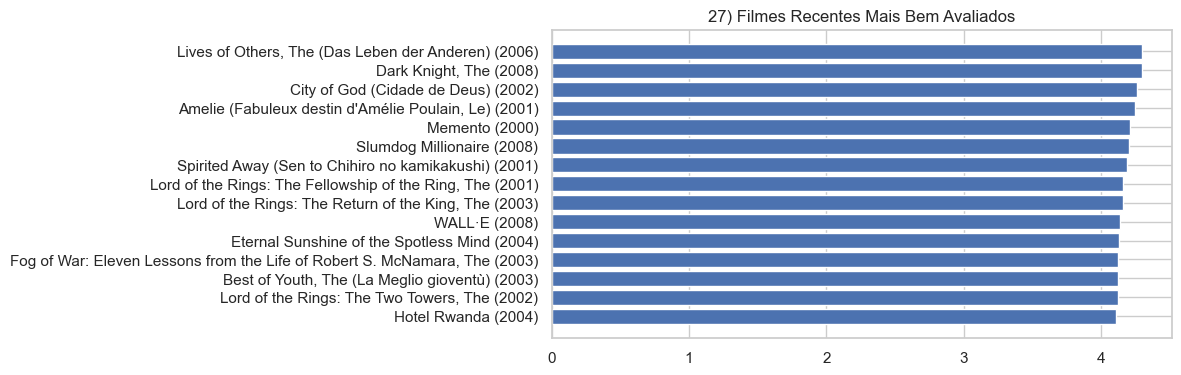


=== 28) Nota média por década ===
shape: (94, 2)
┌────────┬────────────┐
│ decade ┆ avg_rating │
│ ---    ┆ ---        │
│ f64    ┆ f64        │
╞════════╪════════════╡
│ 1915.0 ┆ 3.248768   │
│ 1916.0 ┆ 3.767327   │
│ 1917.0 ┆ 3.805556   │
│ 1918.0 ┆ 3.646341   │
│ 1919.0 ┆ 3.308743   │
│ …      ┆ …          │
│ 2004.0 ┆ 3.531266   │
│ 2005.0 ┆ 3.479449   │
│ 2006.0 ┆ 3.535545   │
│ 2007.0 ┆ 3.5289     │
│ 2008.0 ┆ 3.458922   │
└────────┴────────────┘


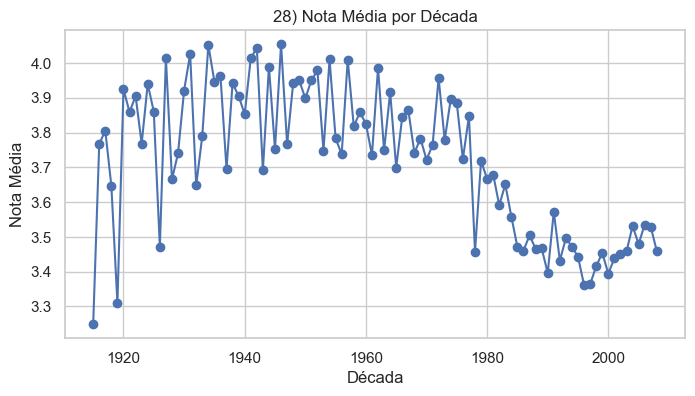


=== 29) Nº de gêneros por filme ===
shape: (9, 3)
┌────────────┬──────────────┬──────────┐
│ statistic  ┆ movieId      ┆ n_genres │
│ ---        ┆ ---          ┆ ---      │
│ str        ┆ f64          ┆ f64      │
╞════════════╪══════════════╪══════════╡
│ count      ┆ 10680.0      ┆ 10680.0  │
│ null_count ┆ 0.0          ┆ 0.0      │
│ mean       ┆ 13120.946255 ┆ 2.019007 │
│ std        ┆ 17809.62936  ┆ 1.029172 │
│ min        ┆ 1.0          ┆ 1.0      │
│ 25%        ┆ 2755.0       ┆ 1.0      │
│ 50%        ┆ 5436.0       ┆ 2.0      │
│ 75%        ┆ 8713.0       ┆ 3.0      │
│ max        ┆ 65133.0      ┆ 8.0      │
└────────────┴──────────────┴──────────┘


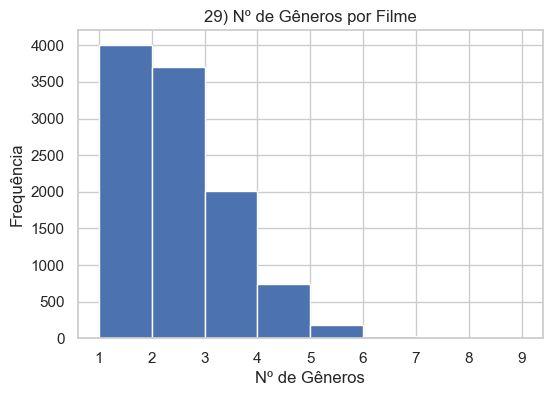


=== 30) Filmes com mais gêneros ===
shape: (15, 2)
┌─────────────────────────────────┬──────────┐
│ title                           ┆ n_genres │
│ ---                             ┆ ---      │
│ str                             ┆ i64      │
╞═════════════════════════════════╪══════════╡
│ Host, The (Gwoemul) (2006)      ┆ 8        │
│ Enchanted (2007)                ┆ 7        │
│ Who Framed Roger Rabbit? (1988… ┆ 7        │
│ Monster House (2006)            ┆ 7        │
│ Meet the Robinsons (2007)       ┆ 6        │
│ …                               ┆ …        │
│ Return of Jafar, The (1994)     ┆ 6        │
│ Song of the Thin Man (1947)     ┆ 6        │
│ Battlestar Galactica: Razor (2… ┆ 6        │
│ Holy Mountain, The (Montaña sa… ┆ 6        │
│ Steamboy (Suchîmubôi) (2004)    ┆ 6        │
└─────────────────────────────────┴──────────┘


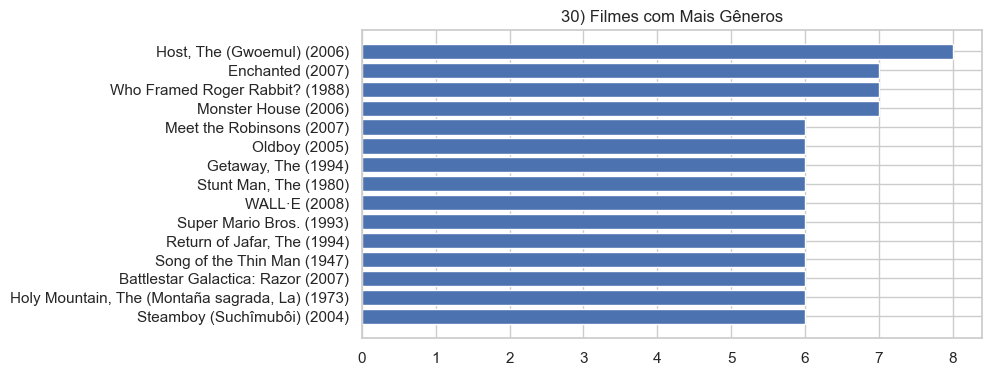

In [68]:
# 21) Filmes mais consensuais (menor desvio padrão)
stat21 = q("""
    SELECT m.title, COUNT(r.rating) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 500
    ORDER BY std ASC
    LIMIT 15
""")
print("=== 21) Filmes mais consensuais ===")
print(stat21)
plt.figure(figsize=(8,4))
plt.barh(stat21["title"], stat21["std"])
plt.title("21) Filmes Mais Consensuais")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "21_filmes_consensuais.png"))
plt.show()

# 22) Nº de tags por usuário
stat22 = q("""
    SELECT userId, COUNT(*) AS n_tags
    FROM tags
    GROUP BY userId
""")
print("\n=== 22) Nº de tags por usuário ===")
print(stat22.describe())
plt.figure(figsize=(6,4))
plt.hist(stat22["n_tags"], bins=50, log=True)
plt.title("22) Nº de Tags por Usuário")
plt.xlabel("Nº de Tags")
plt.ylabel("Frequência (log)")
plt.savefig(os.path.join(output_dir, "22_tags_usuario.png"))
plt.show()

# 23) Tags mais associadas a notas altas (≥4)
stat23 = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM ratings r
    JOIN tags t USING (userId, movieId)
    GROUP BY tag
    HAVING COUNT(*) >= 50
    ORDER BY avg_rating DESC
    LIMIT 20
""")
print("\n=== 23) Tags mais associadas a notas altas ===")
print(stat23)
plt.figure(figsize=(8,4))
plt.barh(stat23["tag"], stat23["avg_rating"])
plt.title("23) Tags Associadas a Notas Altas")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "23_tags_altas.png"))
plt.show()

# 24) Tags mais associadas a notas baixas (≤2)
stat24 = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM ratings r
    JOIN tags t USING (userId, movieId)
    GROUP BY tag
    HAVING COUNT(*) >= 50
    ORDER BY avg_rating ASC
    LIMIT 20
""")
print("\n=== 24) Tags mais associadas a notas baixas ===")
print(stat24)
plt.figure(figsize=(8,4))
plt.barh(stat24["tag"], stat24["avg_rating"])
plt.title("24) Tags Associadas a Notas Baixas")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "24_tags_baixas.png"))
plt.show()

# 25) Evolução da nota média por gênero (exemplo)
stat25 = q("""
    WITH exploded AS (
        SELECT r.rating, DATE_TRUNC('year', TO_TIMESTAMP(r.timestamp)) AS year,
               UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT year, genre, AVG(rating) AS avg_rating
    FROM exploded
    GROUP BY year, genre
    ORDER BY year, genre
""")
print("\n=== 25) Evolução da nota média por gênero (amostra) ===")
print(stat25.head(20))
plt.figure(figsize=(10,5))
for g in stat25["genre"].unique()[:5]:  # plota só alguns gêneros
    subset = stat25.filter(stat25["genre"] == g)
    plt.plot(subset["year"], subset["avg_rating"], label=g)
plt.legend()
plt.title("25) Evolução da Nota Média por Gênero (amostra)")
plt.xlabel("Ano")
plt.ylabel("Nota Média")
plt.savefig(os.path.join(output_dir, "25_evolucao_genero.png"))
plt.show()

# 26) Clássicos antigos mais bem avaliados (antes de 1960)
stat26 = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(r.rating) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE m.title LIKE '%(19%' AND CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) < 1960
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 15
""")
print("\n=== 26) Clássicos antigos mais bem avaliados ===")
print(stat26)
plt.figure(figsize=(8,4))
plt.barh(stat26["title"], stat26["avg_rating"])
plt.title("26) Clássicos Antigos Mais Bem Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "26_classicos_antigos.png"))
plt.show()

# 27) Filmes recentes mais bem avaliados (2000+)
stat27 = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(r.rating) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) >= 2000
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 15
""")
print("\n=== 27) Filmes recentes mais bem avaliados ===")
print(stat27)
plt.figure(figsize=(8,4))
plt.barh(stat27["title"], stat27["avg_rating"])
plt.title("27) Filmes Recentes Mais Bem Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "27_filmes_recentes.png"))
plt.show()

# 28) Nota média por década
stat28 = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           AVG(r.rating) AS avg_rating
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade
    ORDER BY decade
""")
print("\n=== 28) Nota média por década ===")
print(stat28)
plt.figure(figsize=(8,4))
plt.plot(stat28["decade"], stat28["avg_rating"], marker="o")
plt.title("28) Nota Média por Década")
plt.xlabel("Década")
plt.ylabel("Nota Média")
plt.savefig(os.path.join(output_dir, "28_media_decada.png"))
plt.show()

# 29) Nº de gêneros por filme
stat29 = q("""
    SELECT movieId, COUNT(*) AS n_genres
    FROM (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    GROUP BY movieId
""")
print("\n=== 29) Nº de gêneros por filme ===")
print(stat29.describe())
plt.figure(figsize=(6,4))
plt.hist(stat29["n_genres"], bins=range(1,10))
plt.title("29) Nº de Gêneros por Filme")
plt.xlabel("Nº de Gêneros")
plt.ylabel("Frequência")
plt.savefig(os.path.join(output_dir, "29_generos_filme.png"))
plt.show()

# 30) Filmes com mais gêneros
stat30 = q("""
    SELECT m.title, COUNT(*) AS n_genres
    FROM movies m,
         UNNEST(STRING_SPLIT(m.genres, '|')) g
    WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    GROUP BY m.title
    ORDER BY n_genres DESC
    LIMIT 15
""")
print("\n=== 30) Filmes com mais gêneros ===")
print(stat30)
plt.figure(figsize=(8,4))
plt.barh(stat30["title"], stat30["n_genres"])
plt.title("30) Filmes com Mais Gêneros")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "30_filmes_multigenero.png"))
plt.show()


=== 31) Distribuição de notas por década ===
shape: (20, 3)
┌────────┬────────┬─────┐
│ decade ┆ rating ┆ n   │
│ ---    ┆ ---    ┆ --- │
│ f64    ┆ f64    ┆ i64 │
╞════════╪════════╪═════╡
│ 1915.0 ┆ 0.5    ┆ 14  │
│ 1915.0 ┆ 1.0    ┆ 7   │
│ 1915.0 ┆ 1.5    ┆ 5   │
│ 1915.0 ┆ 2.0    ┆ 12  │
│ 1915.0 ┆ 2.5    ┆ 14  │
│ …      ┆ …      ┆ …   │
│ 1916.0 ┆ 4.0    ┆ 24  │
│ 1916.0 ┆ 4.5    ┆ 16  │
│ 1916.0 ┆ 5.0    ┆ 16  │
│ 1917.0 ┆ 0.5    ┆ 1   │
│ 1917.0 ┆ 2.0    ┆ 1   │
└────────┴────────┴─────┘


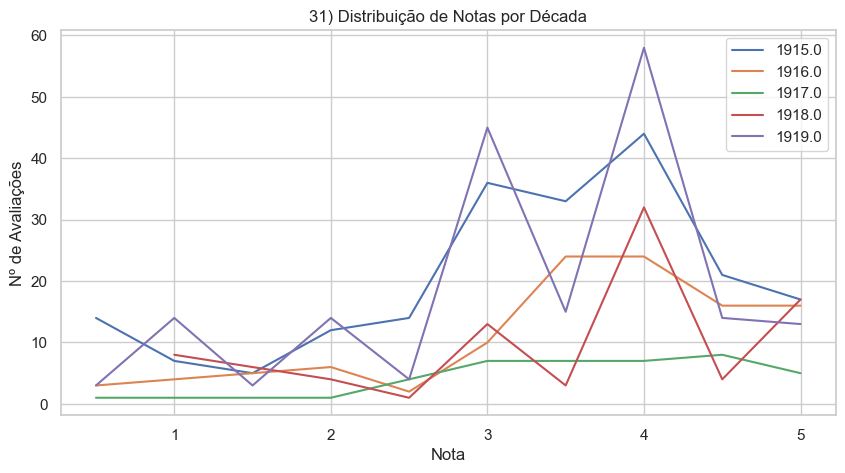


=== 32) Filme mais avaliado por década (Top 1 por década) ===
   decade                                              title  n_ratings
0    1910                      Birth of a Nation, The (1915)        203
1    1920                                  Metropolis (1927)       2733
2    1930                           Wizard of Oz, The (1939)      12851
3    1940                                  Casablanca (1942)      12507
4    1950                                 Rear Window (1954)       8825
5    1960                       2001: A Space Odyssey (1968)      13061
6    1970  Star Wars: Episode IV - A New Hope (a.k.a. Sta...      28566
7    1980                                      Batman (1989)      26996
8    1990                                Pulp Fiction (1994)      34864
9    2000  Lord of the Rings: The Fellowship of the Ring,...      15938


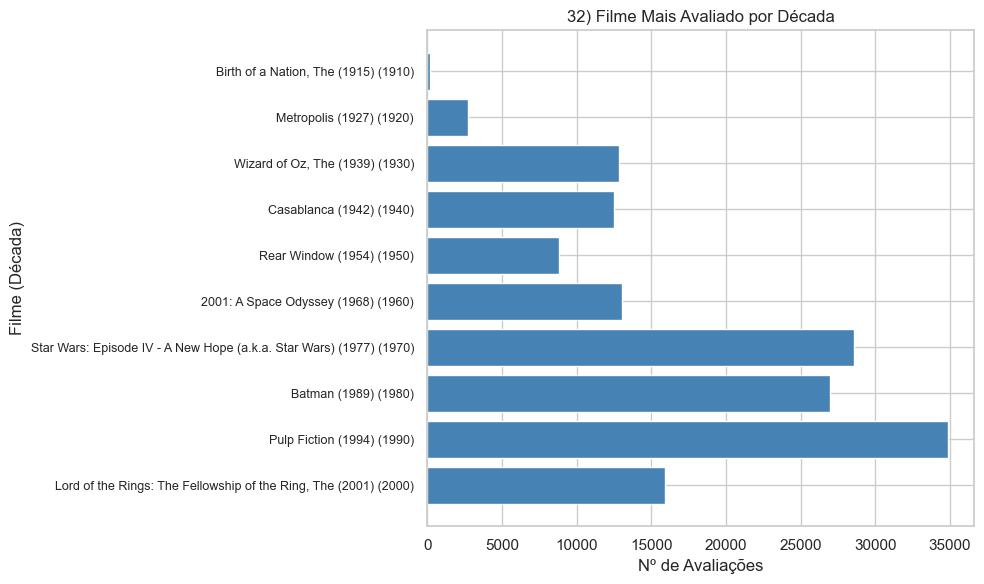


=== 33) Filmes com maior proporção de notas 5 ===
shape: (20, 3)
┌─────────────────────────────────┬──────────┬───────┐
│ title                           ┆ prop_5   ┆ n     │
│ ---                             ┆ ---      ┆ ---   │
│ str                             ┆ f64      ┆ i64   │
╞═════════════════════════════════╪══════════╪═══════╡
│ Godfather, The (1972)           ┆ 0.532603 ┆ 19814 │
│ Shawshank Redemption, The (199… ┆ 0.528818 ┆ 31126 │
│ World of Apu, The (Apur Sansar… ┆ 0.498818 ┆ 423   │
│ Schindler's List (1993)         ┆ 0.497071 ┆ 25777 │
│ Children of Paradise (Les enfa… ┆ 0.479204 ┆ 553   │
│ …                               ┆ …        ┆ …     │
│ Wallace & Gromit: The Best of … ┆ 0.434803 ┆ 4356  │
│ Grand Illusion (Grande illusio… ┆ 0.434679 ┆ 842   │
│ General, The (1927)             ┆ 0.431655 ┆ 1112  │
│ Pulp Fiction (1994)             ┆ 0.429469 ┆ 34864 │
│ Lawrence of Arabia (1962)       ┆ 0.419607 ┆ 6773  │
└─────────────────────────────────┴──────────┴───────┘

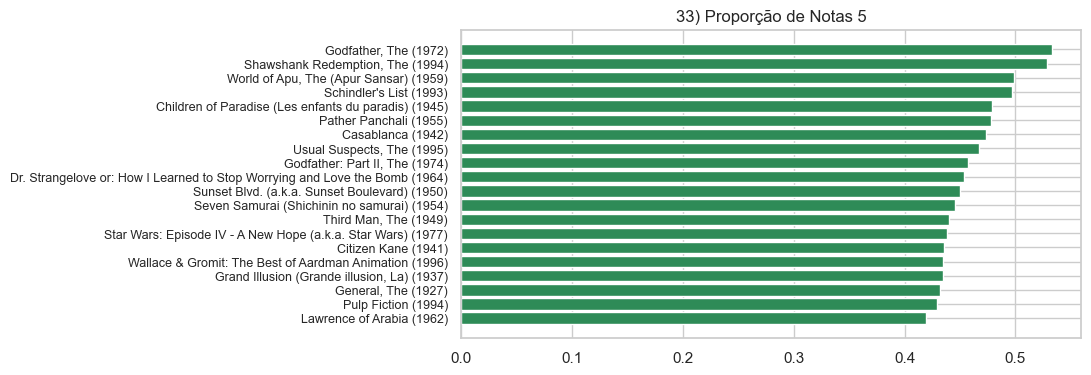


=== 34) Filmes com maior proporção de notas 0.5 ===
shape: (20, 3)
┌─────────────────────────────────┬──────────┬─────┐
│ title                           ┆ prop_05  ┆ n   │
│ ---                             ┆ ---      ┆ --- │
│ str                             ┆ f64      ┆ i64 │
╞═════════════════════════════════╪══════════╪═════╡
│ From Justin to Kelly (2003)     ┆ 0.643519 ┆ 216 │
│ Pokemon 4 Ever (a.k.a. Pokémon… ┆ 0.570815 ┆ 233 │
│ Gigli (2003)                    ┆ 0.485795 ┆ 352 │
│ House of the Dead, The (2003)   ┆ 0.411255 ┆ 231 │
│ Glitter (2001)                  ┆ 0.355263 ┆ 380 │
│ …                               ┆ …        ┆ …   │
│ Turbo: A Power Rangers Movie (… ┆ 0.229545 ┆ 440 │
│ 3 Ninjas Kick Back (1994)       ┆ 0.226148 ┆ 283 │
│ Cat in the Hat, The (2003)      ┆ 0.221411 ┆ 411 │
│ Master of Disguise, The (2002)  ┆ 0.206304 ┆ 349 │
│ Kangaroo Jack (2003)            ┆ 0.194357 ┆ 319 │
└─────────────────────────────────┴──────────┴─────┘


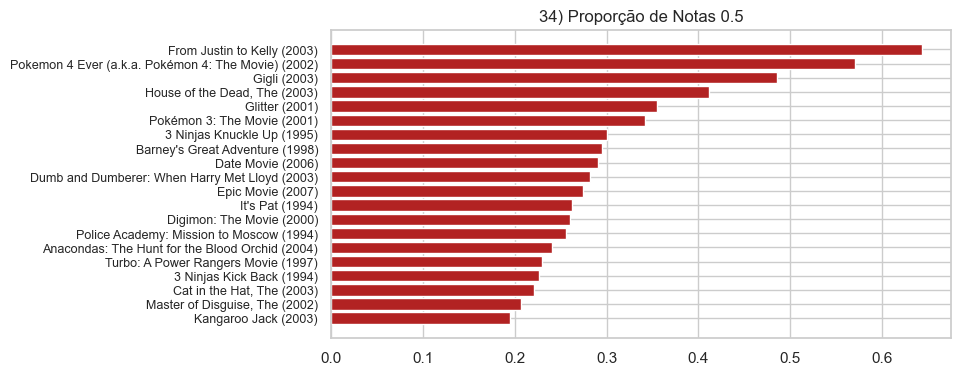


=== 35) Usuários que mais usam notas extremas ===
shape: (20, 3)
┌────────┬───────────────┬─────┐
│ userId ┆ prop_extremas ┆ n   │
│ ---    ┆ ---           ┆ --- │
│ i64    ┆ f64           ┆ i64 │
╞════════╪═══════════════╪═════╡
│ 36022  ┆ 0.981818      ┆ 110 │
│ 5763   ┆ 0.942149      ┆ 242 │
│ 36896  ┆ 0.939394      ┆ 165 │
│ 48518  ┆ 0.92          ┆ 150 │
│ 7605   ┆ 0.917431      ┆ 109 │
│ …      ┆ …             ┆ …   │
│ 11571  ┆ 0.863309      ┆ 139 │
│ 62537  ┆ 0.854077      ┆ 233 │
│ 56443  ┆ 0.853333      ┆ 150 │
│ 24193  ┆ 0.852174      ┆ 115 │
│ 60907  ┆ 0.850932      ┆ 161 │
└────────┴───────────────┴─────┘


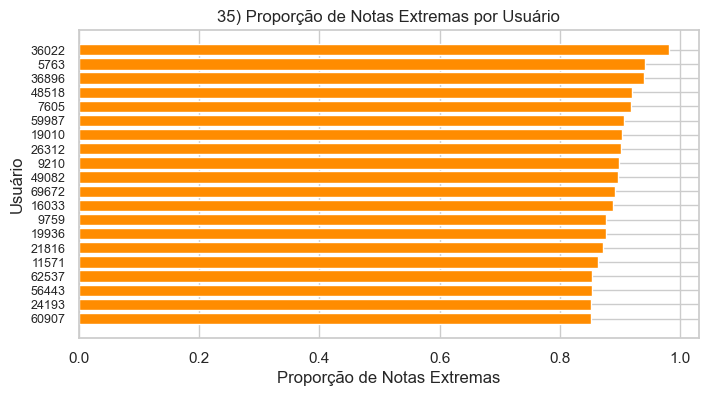


=== 36) Heatmap hora x dia da semana ===
shape: (20, 3)
┌─────┬──────┬───────┐
│ dow ┆ hour ┆ n     │
│ --- ┆ ---  ┆ ---   │
│ i64 ┆ i64  ┆ i64   │
╞═════╪══════╪═══════╡
│ 0   ┆ 0    ┆ 67108 │
│ 0   ┆ 1    ┆ 66748 │
│ 0   ┆ 2    ┆ 63094 │
│ 0   ┆ 3    ┆ 63431 │
│ 0   ┆ 4    ┆ 61941 │
│ …   ┆ …    ┆ …     │
│ 0   ┆ 15   ┆ 50409 │
│ 0   ┆ 16   ┆ 63718 │
│ 0   ┆ 17   ┆ 70416 │
│ 0   ┆ 18   ┆ 68903 │
│ 0   ┆ 19   ┆ 78718 │
└─────┴──────┴───────┘


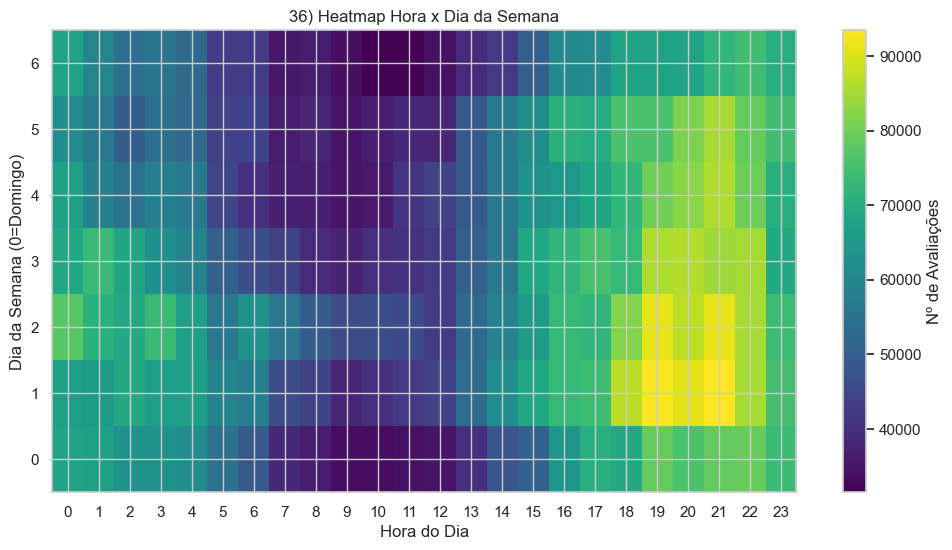


=== 37) Filmes mais tagueados ===
shape: (20, 2)
┌─────────────────────────────────┬────────┐
│ title                           ┆ n_tags │
│ ---                             ┆ ---    │
│ str                             ┆ i64    │
╞═════════════════════════════════╪════════╡
│ Pulp Fiction (1994)             ┆ 308    │
│ Shawshank Redemption, The (199… ┆ 257    │
│ Fight Club (1999)               ┆ 235    │
│ Schindler's List (1993)         ┆ 232    │
│ Matrix, The (1999)              ┆ 223    │
│ …                               ┆ …      │
│ Amelie (Fabuleux destin d'Amél… ┆ 183    │
│ City of God (Cidade de Deus) (… ┆ 183    │
│ Serenity (2005)                 ┆ 181    │
│ Memento (2000)                  ┆ 179    │
│ Seven (a.k.a. Se7en) (1995)     ┆ 177    │
└─────────────────────────────────┴────────┘


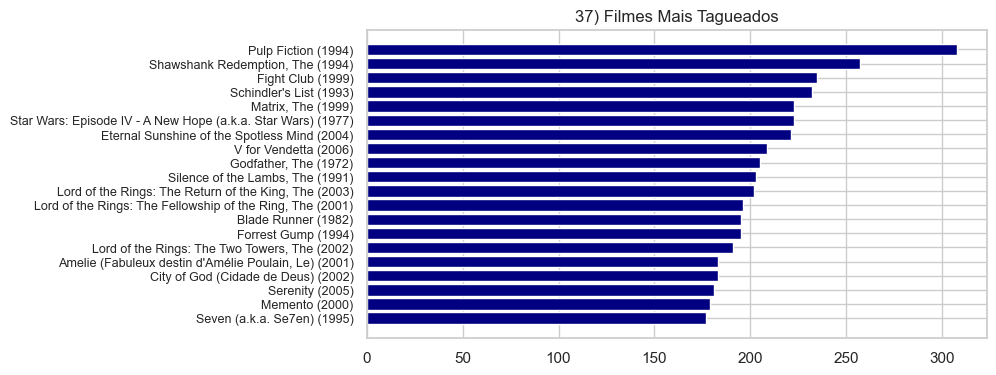


=== 38) Tag mais popular por década (Top 1 por década) ===
   decade                              tag    n
0    1910  white film theory and criticism    2
1    1920                          classic    5
2    1930                          classic   29
3    1940                           disney   22
4    1950                          classic   17
5    1960                          classic   21
6    1970                           sci-fi   20
7    1980                            anime   37
8    1990                quentin tarantino   42
9    2000                                r  111


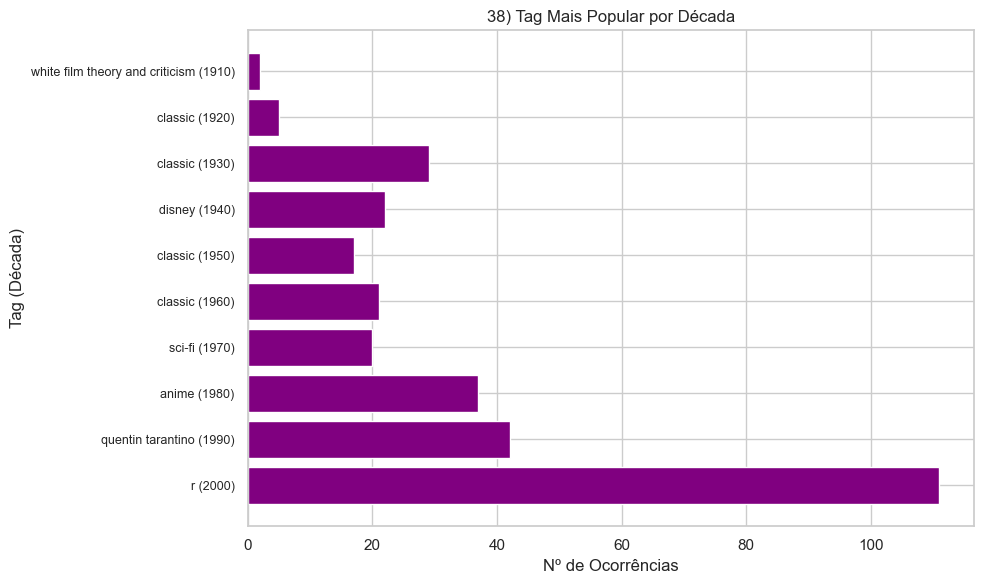


=== 39) Filmes com maior variação de notas ao longo do tempo ===
shape: (20, 3)
┌─────────────────────────────────┬──────────┬───────────┐
│ title                           ┆ std_time ┆ n_periods │
│ ---                             ┆ ---      ┆ ---       │
│ str                             ┆ f64      ┆ i64       │
╞═════════════════════════════════╪══════════╪═══════════╡
│ Madagascar Skin (1995)          ┆ 1.752792 ┆ 6         │
│ Alley Cats, The (1966)          ┆ 1.635543 ┆ 5         │
│ Tainted (1998)                  ┆ 1.635543 ┆ 6         │
│ Letter From Death Row, A (1998… ┆ 1.624181 ┆ 6         │
│ Haunted Castle (2001)           ┆ 1.615983 ┆ 6         │
│ …                               ┆ …        ┆ …         │
│ Walk on Water (2004)            ┆ 1.46889  ┆ 5         │
│ Deathmaker, The (Der Totmacher… ┆ 1.46534  ┆ 5         │
│ Summertime (1955)               ┆ 1.454386 ┆ 6         │
│ Und keiner weint mir nach (199… ┆ 1.451688 ┆ 5         │
│ Never Play Clever Again (Le Ge… 

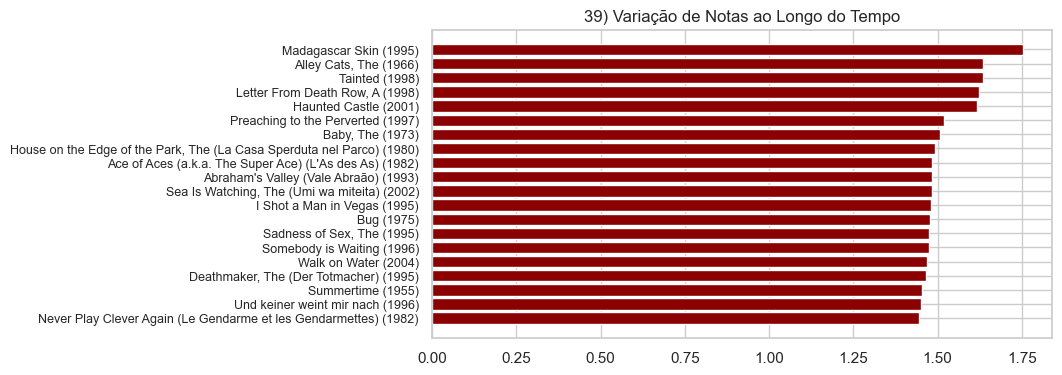


=== 40) Evolução da quantidade de tags ao longo do tempo ===
shape: (5, 2)
┌─────────────────────────────┬────────┐
│ ano                         ┆ n_tags │
│ ---                         ┆ ---    │
│ datetime[μs, Europe/London] ┆ i64    │
╞═════════════════════════════╪════════╡
│ 2005-01-01 00:00:00 GMT     ┆ 38     │
│ 2006-01-01 00:00:00 GMT     ┆ 36163  │
│ 2007-01-01 00:00:00 GMT     ┆ 36395  │
│ 2008-01-01 00:00:00 GMT     ┆ 22674  │
│ 2009-01-01 00:00:00 GMT     ┆ 310    │
└─────────────────────────────┴────────┘


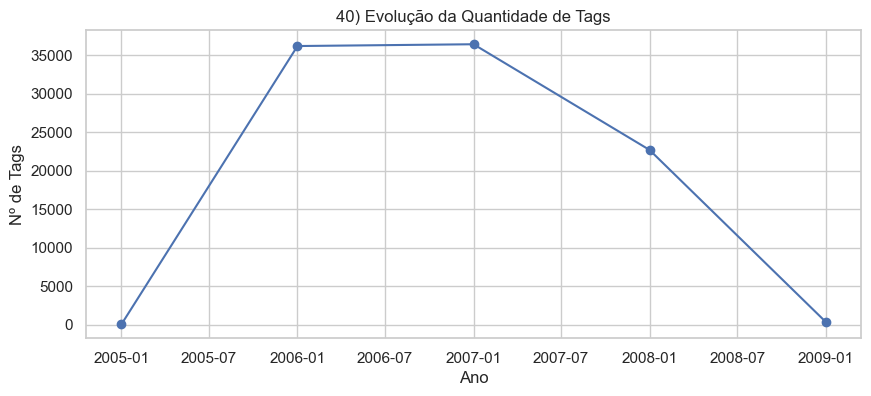


=== 41) Filmes mais avaliados em finais de semana ===
shape: (20, 2)
┌─────────────────────────────────┬──────┐
│ title                           ┆ n    │
│ ---                             ┆ ---  │
│ str                             ┆ i64  │
╞═════════════════════════════════╪══════╡
│ Pulp Fiction (1994)             ┆ 8775 │
│ Forrest Gump (1994)             ┆ 8768 │
│ Silence of the Lambs, The (199… ┆ 8500 │
│ Jurassic Park (1993)            ┆ 8264 │
│ Shawshank Redemption, The (199… ┆ 7945 │
│ …                               ┆ …    │
│ Star Wars: Episode VI - Return… ┆ 6382 │
│ True Lies (1994)                ┆ 6359 │
│ Fargo (1996)                    ┆ 6224 │
│ Matrix, The (1999)              ┆ 6024 │
│ 12 Monkeys (Twelve Monkeys) (1… ┆ 6018 │
└─────────────────────────────────┴──────┘


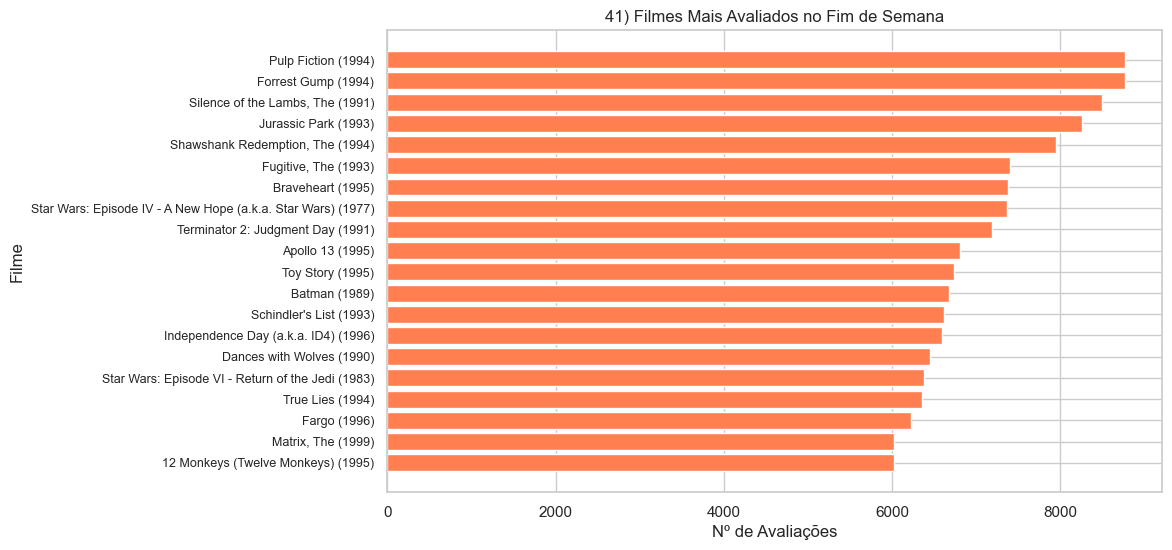


=== 42) Filmes mais avaliados em dias úteis ===
shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ title                           ┆ n     │
│ ---                             ┆ ---   │
│ str                             ┆ i64   │
╞═════════════════════════════════╪═══════╡
│ Pulp Fiction (1994)             ┆ 26089 │
│ Forrest Gump (1994)             ┆ 25689 │
│ Silence of the Lambs, The (199… ┆ 25168 │
│ Jurassic Park (1993)            ┆ 24367 │
│ Shawshank Redemption, The (199… ┆ 23181 │
│ …                               ┆ …     │
│ True Lies (1994)                ┆ 19022 │
│ Star Wars: Episode VI - Return… ┆ 18716 │
│ 12 Monkeys (Twelve Monkeys) (1… ┆ 18379 │
│ Usual Suspects, The (1995)      ┆ 18063 │
│ Speed (1994)                    ┆ 17774 │
└─────────────────────────────────┴───────┘


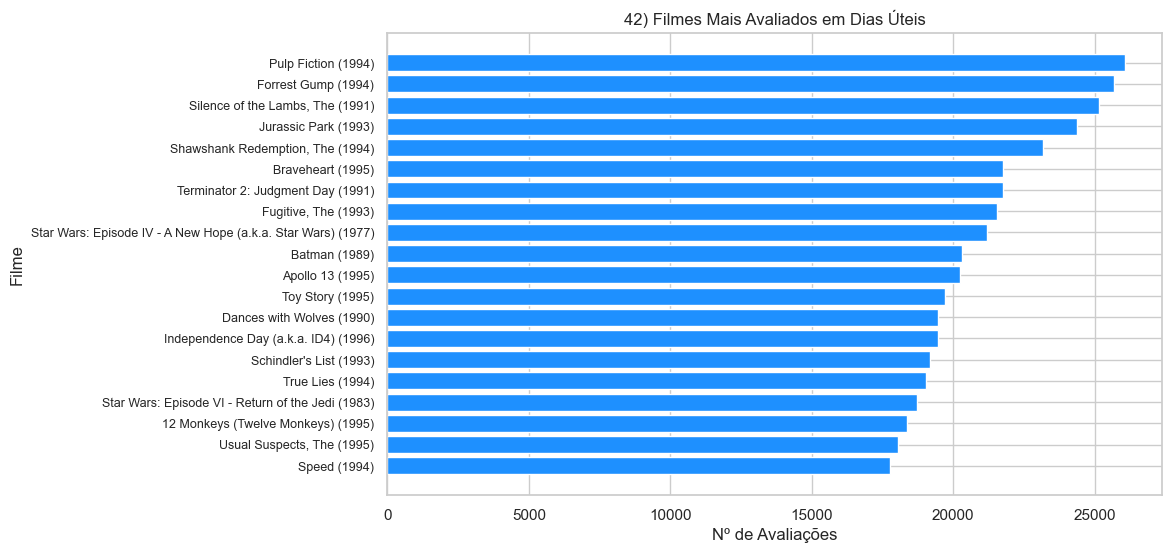


=== 43) Diferença de média semana vs fim de semana ===
shape: (20, 4)
┌─────────────────────────────────┬────────────┬──────────┬───────────┐
│ title                           ┆ avg_semana ┆ avg_fds  ┆ diff      │
│ ---                             ┆ ---        ┆ ---      ┆ ---       │
│ str                             ┆ f64        ┆ f64      ┆ f64       │
╞═════════════════════════════════╪════════════╪══════════╪═══════════╡
│ Texas Chainsaw Massacre, The (… ┆ 2.840404   ┆ 2.511976 ┆ -0.328428 │
│ Boy Who Could Fly, The (1986)   ┆ 2.986438   ┆ 3.288557 ┆ 0.30212   │
│ Halloween III: Season of the W… ┆ 1.791667   ┆ 2.092308 ┆ 0.300641  │
│ Swan Princess, The (1994)       ┆ 2.912473   ┆ 3.200581 ┆ 0.288109  │
│ Mighty Joe Young (1949)         ┆ 3.020681   ┆ 3.3      ┆ 0.279319  │
│ …                               ┆ …          ┆ …        ┆ …         │
│ Detroit Rock City (1999)        ┆ 3.021135   ┆ 3.264493 ┆ 0.243357  │
│ Doc Hollywood (1991)            ┆ 2.920912   ┆ 3.161585 ┆ 0.240

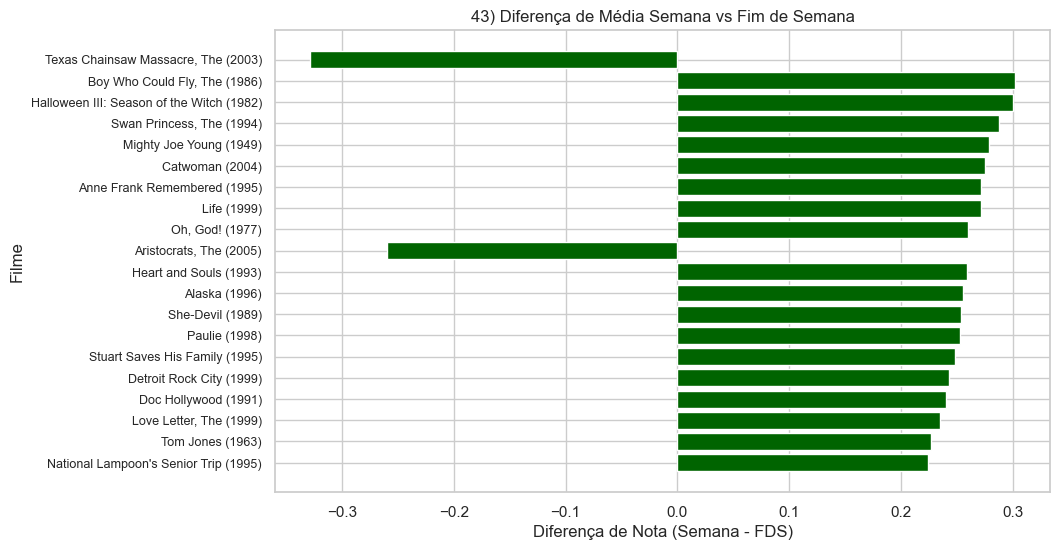


=== 44) Filmes com maior crescimento de avaliações ===
shape: (20, 2)
┌─────────────────────────────────┬─────────────┐
│ title                           ┆ crescimento │
│ ---                             ┆ ---         │
│ str                             ┆ i64         │
╞═════════════════════════════════╪═════════════╡
│ Batman (1989)                   ┆ 13350       │
│ Dances with Wolves (1990)       ┆ 12732       │
│ Apollo 13 (1995)                ┆ 12693       │
│ Fugitive, The (1993)            ┆ 12127       │
│ True Lies (1994)                ┆ 12036       │
│ …                               ┆ …           │
│ Stargate (1994)                 ┆ 9797        │
│ Shawshank Redemption, The (199… ┆ 9648        │
│ Outbreak (1995)                 ┆ 9368        │
│ Star Trek: Generations (1994)   ┆ 9207        │
│ Cliffhanger (1993)              ┆ 9071        │
└─────────────────────────────────┴─────────────┘


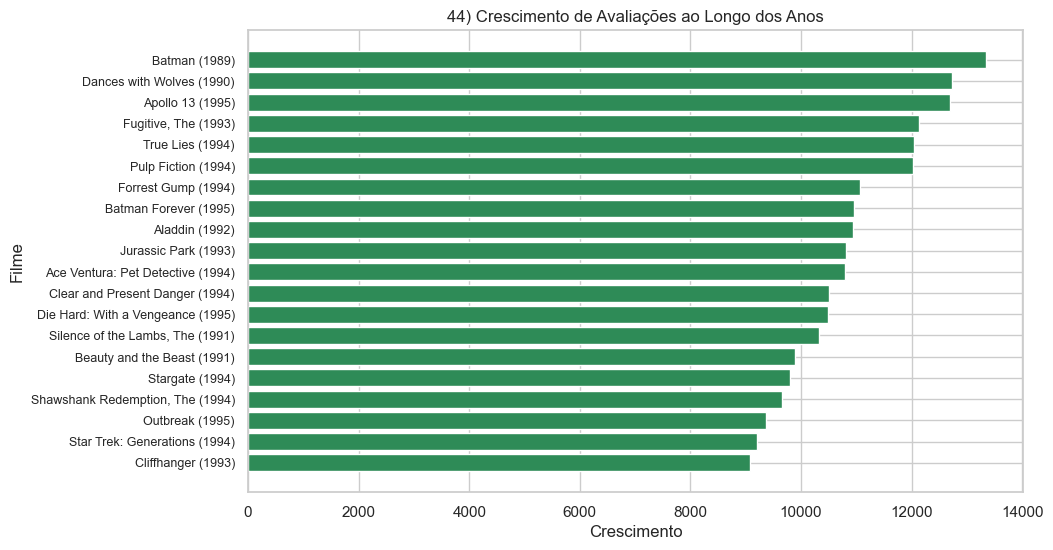


=== 45) Filmes com maior queda de popularidade ===
shape: (20, 2)
┌─────────────────────────────────┬────────┐
│ title                           ┆ queda  │
│ ---                             ┆ ---    │
│ str                             ┆ i64    │
╞═════════════════════════════════╪════════╡
│ Batman (1989)                   ┆ -13350 │
│ Dances with Wolves (1990)       ┆ -12732 │
│ Apollo 13 (1995)                ┆ -12693 │
│ Fugitive, The (1993)            ┆ -12127 │
│ True Lies (1994)                ┆ -12036 │
│ …                               ┆ …      │
│ Stargate (1994)                 ┆ -9797  │
│ Shawshank Redemption, The (199… ┆ -9648  │
│ Outbreak (1995)                 ┆ -9368  │
│ Star Trek: Generations (1994)   ┆ -9207  │
│ Cliffhanger (1993)              ┆ -9071  │
└─────────────────────────────────┴────────┘


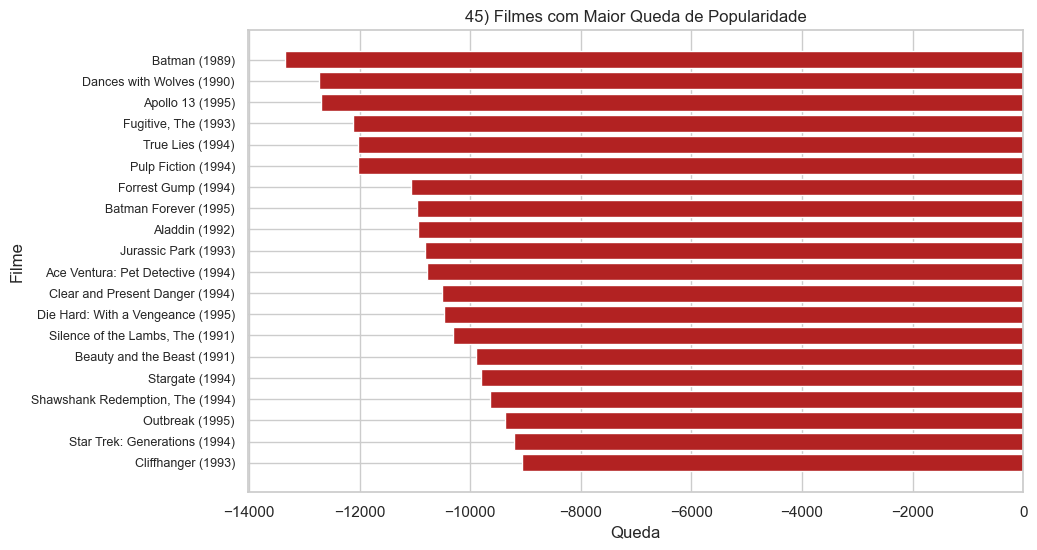


=== 46) Usuários mais consistentes ===
shape: (20, 3)
┌────────┬──────────┬─────┐
│ userId ┆ std_user ┆ n   │
│ ---    ┆ ---      ┆ --- │
│ i64    ┆ f64      ┆ i64 │
╞════════╪══════════╪═════╡
│ 24176  ┆ 0.0      ┆ 147 │
│ 29110  ┆ 0.0      ┆ 203 │
│ 5763   ┆ 0.258228 ┆ 242 │
│ 47202  ┆ 0.272561 ┆ 157 │
│ 59987  ┆ 0.331054 ┆ 226 │
│ …      ┆ …        ┆ …   │
│ 16713  ┆ 0.383169 ┆ 164 │
│ 23696  ┆ 0.384688 ┆ 119 │
│ 57740  ┆ 0.385163 ┆ 116 │
│ 47780  ┆ 0.3889   ┆ 120 │
│ 31677  ┆ 0.395674 ┆ 328 │
└────────┴──────────┴─────┘


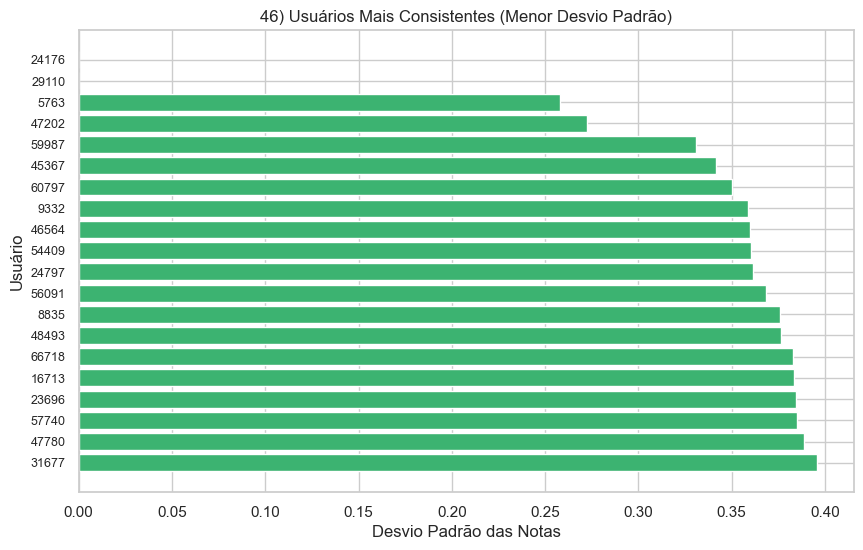


=== 47) Usuários mais inconsistentes ===
shape: (20, 3)
┌────────┬──────────┬──────┐
│ userId ┆ std_user ┆ n    │
│ ---    ┆ ---      ┆ ---  │
│ i64    ┆ f64      ┆ i64  │
╞════════╪══════════╪══════╡
│ 62537  ┆ 2.108368 ┆ 233  │
│ 11760  ┆ 2.040698 ┆ 2213 │
│ 6925   ┆ 1.984823 ┆ 175  │
│ 70321  ┆ 1.957742 ┆ 432  │
│ 26312  ┆ 1.944184 ┆ 101  │
│ …      ┆ …        ┆ …    │
│ 6369   ┆ 1.796606 ┆ 105  │
│ 16803  ┆ 1.789627 ┆ 104  │
│ 53844  ┆ 1.787297 ┆ 115  │
│ 17511  ┆ 1.784302 ┆ 259  │
│ 53046  ┆ 1.783579 ┆ 118  │
└────────┴──────────┴──────┘


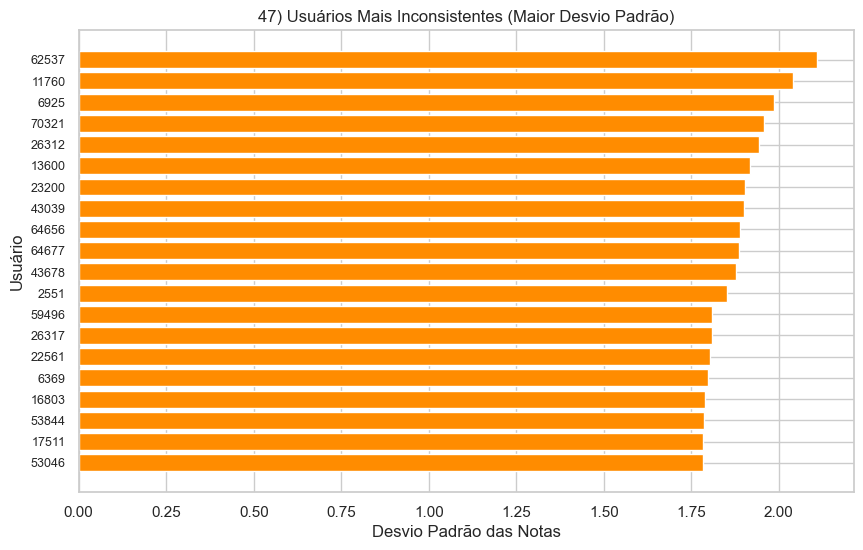

In [87]:
# 31) Distribuição de notas por década
print("\n=== 31) Distribuição de notas por década ===")
print(stat31.head(20))
plt.figure(figsize=(10,5))
for dec in stat31["decade"].unique()[:5]:
    subset = stat31.filter(stat31["decade"] == dec)
    plt.plot(subset["rating"], subset["n"], label=str(dec))
plt.legend()
plt.title("31) Distribuição de Notas por Década")
plt.xlabel("Nota")
plt.ylabel("Nº de Avaliações")
plt.savefig(os.path.join(output_dir, "31_notas_decada.png"))
plt.show()

# 32) Filme mais avaliado por década (Top 1 por década, Y = título + década)
print("\n=== 32) Filme mais avaliado por década (Top 1 por década) ===")
df32 = stat32.to_pandas().copy()

# garantir década correta
df32["decade"] = (df32["decade"] // 10 * 10).astype(int)

# pegar o filme mais avaliado em cada década
df32_top = df32.sort_values(["decade", "n_ratings"], ascending=[True, False]) \
               .groupby("decade", as_index=False).first()

# criar rótulo "Título (Década)"
df32_top["label"] = df32_top["title"] + " (" + df32_top["decade"].astype(str) + ")"

print(df32_top[["decade","title","n_ratings"]])

plt.figure(figsize=(10,6))
y_pos = range(len(df32_top))
plt.barh(y_pos, df32_top["n_ratings"], color="steelblue")
plt.yticks(y_pos, df32_top["label"], fontsize=9)
plt.title("32) Filme Mais Avaliado por Década")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Filme (Década)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "32_filmes_decada_top1.png"))
plt.show()

# 33) Filmes com maior proporção de notas 5
print("\n=== 33) Filmes com maior proporção de notas 5 ===")
print(stat33)
plt.figure(figsize=(8,4))
y_pos = range(len(stat33))
plt.barh(y_pos, stat33["prop_5"], color="seagreen")
plt.yticks(y_pos, stat33["title"], fontsize=9)
plt.title("33) Proporção de Notas 5")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "33_prop5.png"))
plt.show()

# 34) Filmes com maior proporção de notas 0.5
print("\n=== 34) Filmes com maior proporção de notas 0.5 ===")
print(stat34)
plt.figure(figsize=(8,4))
y_pos = range(len(stat34))
plt.barh(y_pos, stat34["prop_05"], color="firebrick")
plt.yticks(y_pos, stat34["title"], fontsize=9)
plt.title("34) Proporção de Notas 0.5")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "34_prop05.png"))
plt.show()

# 35) Usuários que mais usam notas extremas
print("\n=== 35) Usuários que mais usam notas extremas ===")
print(stat35)
df35 = stat35.to_pandas()
plt.figure(figsize=(8,4))
y_pos = range(len(df35))
plt.barh(y_pos, df35["prop_extremas"], color="darkorange")
plt.yticks(y_pos, df35["userId"].astype(str), fontsize=9)
plt.title("35) Proporção de Notas Extremas por Usuário")
plt.xlabel("Proporção de Notas Extremas")
plt.ylabel("Usuário")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "35_extremos.png"))
plt.show()

# 36) Heatmap hora x dia da semana
print("\n=== 36) Heatmap hora x dia da semana ===")
print(stat36.head(20))
pivot36 = stat36.to_pandas().pivot(index="dow", columns="hour", values="n")
plt.figure(figsize=(12,6))
plt.imshow(pivot36, aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Nº de Avaliações")
plt.xticks(range(len(pivot36.columns)), pivot36.columns)
plt.yticks(range(len(pivot36.index)), pivot36.index)
plt.title("36) Heatmap Hora x Dia da Semana")
plt.xlabel("Hora do Dia")
plt.ylabel("Dia da Semana (0=Domingo)")
plt.savefig(os.path.join(output_dir, "36_heatmap.png"))
plt.show()

# 37) Filmes mais tagueados
print("\n=== 37) Filmes mais tagueados ===")
print(stat37)
plt.figure(figsize=(8,4))
y_pos = range(len(stat37))
plt.barh(y_pos, stat37["n_tags"], color="navy")
plt.yticks(y_pos, stat37["title"], fontsize=9)
plt.title("37) Filmes Mais Tagueados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "37_filmes_tagueados.png"))
plt.show()

# 38) Tag mais popular por década (Top 1 por década, Y = tag + década)
print("\n=== 38) Tag mais popular por década (Top 1 por década) ===")
df38 = stat38.to_pandas().copy()

# garantir década correta
df38["decade"] = (df38["decade"] // 10 * 10).astype(int)

# pegar a tag mais popular em cada década
df38_top = df38.sort_values(["decade", "n"], ascending=[True, False]) \
               .groupby("decade", as_index=False).first()

# criar rótulo "Tag (Década)"
df38_top["label"] = df38_top["tag"] + " (" + df38_top["decade"].astype(str) + ")"

print(df38_top[["decade","tag","n"]])

plt.figure(figsize=(10,6))
y_pos = range(len(df38_top))
plt.barh(y_pos, df38_top["n"], color="purple")
plt.yticks(y_pos, df38_top["label"], fontsize=9)
plt.title("38) Tag Mais Popular por Década")
plt.xlabel("Nº de Ocorrências")
plt.ylabel("Tag (Década)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "38_tags_decada_top1.png"))
plt.show()
# 39) Filmes com maior variação de notas ao longo do tempo
print("\n=== 39) Filmes com maior variação de notas ao longo do tempo ===")
print(stat39)
plt.figure(figsize=(8,4))
y_pos = range(len(stat39))
plt.barh(y_pos, stat39["std_time"], color="darkred")
plt.yticks(y_pos, stat39["title"], fontsize=9)
plt.title("39) Variação de Notas ao Longo do Tempo")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "39_variacao_tempo.png"))
plt.show()

# 40) Evolução da quantidade de tags ao longo do tempo
print("\n=== 40) Evolução da quantidade de tags ao longo do tempo ===")
print(stat40.head(20))
plt.figure(figsize=(10,4))
plt.plot(stat40["ano"], stat40["n_tags"], marker="o")
plt.title("40) Evolução da Quantidade de Tags")
plt.xlabel("Ano")
plt.ylabel("Nº de Tags")
plt.savefig(os.path.join(output_dir, "40_tags_tempo.png"))
plt.show()

# 41) Filmes mais avaliados em finais de semana
print("\n=== 41) Filmes mais avaliados em finais de semana ===")
print(stat44)
plt.figure(figsize=(10,6))
y_pos = range(len(stat44))
plt.barh(y_pos, stat44["n"], color="coral")
plt.yticks(y_pos, stat44["title"], fontsize=9)
plt.title("41) Filmes Mais Avaliados no Fim de Semana")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "41_filmes_fds.png"))
plt.show()


# 42) Filmes mais avaliados em dias úteis
print("\n=== 42) Filmes mais avaliados em dias úteis ===")
print(stat45)
plt.figure(figsize=(10,6))
y_pos = range(len(stat45))
plt.barh(y_pos, stat45["n"], color="dodgerblue")
plt.yticks(y_pos, stat45["title"], fontsize=9)
plt.title("42) Filmes Mais Avaliados em Dias Úteis")
plt.xlabel("Nº de Avaliações")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "42_filmes_semana.png"))
plt.show()


# 43) Diferença de média semana vs fim de semana
print("\n=== 43) Diferença de média semana vs fim de semana ===")
print(stat46)
plt.figure(figsize=(10,6))
y_pos = range(len(stat46))
plt.barh(y_pos, stat46["diff"], color="darkgreen")
plt.yticks(y_pos, stat46["title"], fontsize=9)
plt.title("43) Diferença de Média Semana vs Fim de Semana")
plt.xlabel("Diferença de Nota (Semana - FDS)")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "43_diff_semana_fds.png"))
plt.show()


# 44) Filmes com maior crescimento de avaliações
print("\n=== 44) Filmes com maior crescimento de avaliações ===")
print(stat47)
plt.figure(figsize=(10,6))
y_pos = range(len(stat47))
plt.barh(y_pos, stat47["crescimento"], color="seagreen")
plt.yticks(y_pos, stat47["title"], fontsize=9)
plt.title("44) Crescimento de Avaliações ao Longo dos Anos")
plt.xlabel("Crescimento")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "44_crescimento.png"))
plt.show()


# 45) Filmes com maior queda de popularidade
print("\n=== 45) Filmes com maior queda de popularidade ===")
print(stat48)
plt.figure(figsize=(10,6))
y_pos = range(len(stat48))
plt.barh(y_pos, stat48["queda"], color="firebrick")
plt.yticks(y_pos, stat48["title"], fontsize=9)
plt.title("45) Filmes com Maior Queda de Popularidade")
plt.xlabel("Queda")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "45_queda_popularidade.png"))
plt.show()


# 46) Usuários mais consistentes
print("\n=== 46) Usuários mais consistentes ===")
print(stat49)
df46 = stat49.to_pandas()
plt.figure(figsize=(10,6))
y_pos = range(len(df46))
plt.barh(y_pos, df46["std_user"], color="mediumseagreen")
plt.yticks(y_pos, df46["userId"].astype(str), fontsize=9)
plt.title("46) Usuários Mais Consistentes (Menor Desvio Padrão)")
plt.xlabel("Desvio Padrão das Notas")
plt.ylabel("Usuário")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "46_usuarios_consistentes.png"))
plt.show()


# 47) Usuários mais inconsistentes
print("\n=== 47) Usuários mais inconsistentes ===")
print(stat50)
df47 = stat50.to_pandas()
plt.figure(figsize=(10,6))
y_pos = range(len(df47))
plt.barh(y_pos, df47["std_user"], color="darkorange")
plt.yticks(y_pos, df47["userId"].astype(str), fontsize=9)
plt.title("47) Usuários Mais Inconsistentes (Maior Desvio Padrão)")
plt.xlabel("Desvio Padrão das Notas")
plt.ylabel("Usuário")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "47_usuarios_inconsistentes.png"))
plt.show()